# Trabajo 2: *Preparación de datos*

En este proyecto, enmarcado en la asignatura *Preparación de Datos* del *Máster en Ciencia de Datos e Inteligencia Artificial*, realizaremos un estudio completo de un dataset en materia de preprocesamiento de datos.

Para ello, emplearemos una parte del [AVONET Dataset](https://figshare.com/articles/dataset/AVONET_morphological_ecological_and_geographical_data_for_all_birds_Tobias_et_al_2021_Ecology_Letters_/16586228/5), producto del estudio publicado como [AVONET: morphological, ecological and geographical data for all birds](https://onlinelibrary.wiley.com/doi/10.1111/ele.13898). Este conjunto de datos contiene información morfológica, ecológica y geográfica sobre distintas aves. Para nuestro trabajo, nos centramos en el problema de clasificación derivado del estudio morfológico de dos órdenes de aves similares en cuanto a su origen y características: los passeriformes (aves cantoras) y los piciformes (pájaros carpinteros, tucanes, etc.).

El dataset que hemos extraído contiene, por tanto, la siguiente información de cada especimen:

* *Unique.Specimen.Identifier*: Especie del especimen.
* *Family1*: Familia del especimen.
* *Order1*: Orden del especimen (variable "target").
* *Sequence*: Número identificador del momento en el que se agrega el registro a la BD.
* *Specimen.number*: Número identificador del especimen.
* *Source*: Fuente de la que provienen los datos.
* *Sex*: Sexo del especimen.
* *Beak.Length_Culmen*: Longitud del culmen del pico.
* *Beak.Length_Nares*: Longitud de los orificios nasales.
* *Beak.width*: Anchura del pico.
* *Beak.Depth*: Profundidad del pico.
* *Tarsus.Length*: Longitud del tarso.
* *Wing.Length*: Longitud del ala.
* *Kipps.Distance*: Distancia del gradiente longitudinal de las alas.
* *Secondary1*: Longitud del conjunto de plumas secundarias.
* *Hand-wing.Index*: 
* *Tail.Length*: Longitud de la cola.
* *Sample.Number*: Número de registros con este especimen en el dataset completo.
* *Measurer*: Entidad que aporta las mediciones.
* *Avonet.Protocol.Used*: Protocolo interno de AVONET.
* *Protocol.both.pairs*: Protocolo interno de AVONET.
* *Protocol.neither.pair*: Protocolo interno de AVONET.

Nuestro objetivo, por tanto, será identificar las técnicas de preprocesamiento de datos que maximicen la eficiencia de una serie de modelos propuestos de aprendizaje automático.

## 0. Importación de paquetes

Importamos los paquetes que utilizaremos en el desarrollo del proyecto.

In [9]:
# !pip install imblearn

  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0


In [10]:
import numpy as np
import pandas as pd

In [11]:
from matplotlib import pyplot

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, ClassifierMixin, clone

In [13]:
from sklearn.feature_selection import VarianceThreshold

In [14]:
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn import linear_model
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer 

In [15]:
from sklearn.neighbors import LocalOutlierFactor

In [16]:
from collections import Counter
from imblearn.over_sampling import ADASYN

In [17]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [18]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import KBinsDiscretizer

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance

In [20]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel

In [21]:
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [22]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

In [23]:
from sklearn.metrics import accuracy_score

In [24]:
import warnings
warnings.filterwarnings('ignore')

## 1. Lectura y análisis del dataset

### 1.1. Importación de datos

Leemos los datos del archivo CSV. Debemos indicar el delimitador ';', que es el que se emplea, y la forma en la que se identifican los valores faltantes.

In [25]:
df = pd.read_csv('Birds.csv', delimiter=';', na_values='NA') #leer dataset

### 1.2. Estudio inicial del dataset

Lo primero que hacemos es mostrar el tamaño del dataset. Vemos que contamos con las 22 columnas asociadas a las variables que acabamos de definir, y con un total de 7.343 registros totales.

In [26]:
print(df.shape) 

(7343, 22)


Mostramos los primeros 5 registros para ver qué forma tienen los datos. Vemos que hay columnas con identificadores de tipo string, una alta cantidad de valores nulos, pero en general datos con un formato estandarizado y homogéneo.

In [27]:
df.head()

,Unique.Specimen.Identifier,Family1,Order1,Sequence,Specimen.number,Source,Sex,Beak.Length_Culmen,Beak.Length_Nares,Beak.Width,...,Wing.Length,Kipps.Distance,Secondary1,Hand-wing.Index,Tail.Length,Sample.Number,Measurer,Avonet.Protocol.Used,Protocol.both.pairs,Protocol.neither.pair
0,Abroscopus schisticeps_86.4.1.3320,Scotocercidae,PASSERIFORMES,8021,86.4.1.3320,NHMUK,M,"8,8","4,5","2,7",...,48,"8,4","39,6","17,5",48,2,CS,1,0,0
1,Abroscopus schisticeps_86.4.1.3320,Scotocercidae,PASSERIFORMES,8021,86.4.1.3320,NHMUK,M,"9,1",NaN,"2,5",...,51,NaN,NaN,NaN,45,1,GT,0,0,0
2,Acanthagenys rufogularis_1965.43.1168,Meliphagidae,PASSERIFORMES,6128,1965.43.1168,NHMUK,M,"28,7",NaN,"4,2",...,115,NaN,NaN,NaN,115,1,GT,0,0,0
3,Acanthagenys rufogularis_1965.43.1168,Meliphagidae,PASSERIFORMES,6128,1965.43.1168,NHMUK,M,"26,5","12,5","3,8",...,115,"25,9","89,1","22,5",114,2,NS,1,0,0
4,Acanthidops bairdi_1899.2.1.846,Thraupidae,PASSERIFORMES,11013,1899.2.1.846,NHMUK,M,"14,3",NaN,4,...,65,NaN,NaN,NaN,63,2,GT,0,0,0


Pasamos a mostrar una información más detallada de las variables del dataset. Vemos que la mayor parte de variables nos las encontramos en formato `'object'`, por lo que tendremos que modificar los tipos de las variables numéricas. También podemos confirmar la alta cantidad de valores nulos.

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7343 entries, 0 to 7342
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Unique.Specimen.Identifier  7343 non-null   object
 1   Family1                     7343 non-null   object
 2   Order1                      7343 non-null   object
 3   Sequence                    7343 non-null   int64 
 4   Specimen.number             7343 non-null   object
 5   Source                      7343 non-null   object
 6   Sex                         7343 non-null   object
 7   Beak.Length_Culmen          7229 non-null   object
 8   Beak.Length_Nares           3535 non-null   object
 9   Beak.Width                  6602 non-null   object
 10  Beak.Depth                  6915 non-null   object
 11  Tarsus.Length               6660 non-null   object
 12  Wing.Length                 7303 non-null   object
 13  Kipps.Distance              4771 non-null   obje

Modificamos los tipos de las variables numéricas y volvemos a mostrar la información.

In [29]:
df['Beak.Length_Culmen'] = df['Beak.Length_Culmen'].str.replace(',', '.').astype('float')
df['Beak.Length_Nares'] = df['Beak.Length_Nares'].str.replace(',', '.').astype('float')
df['Beak.Width'] = df['Beak.Width'].str.replace(',', '.').astype('float')
df['Beak.Depth'] = df['Beak.Depth'].str.replace(',', '.').astype('float')
df['Tarsus.Length'] = df['Tarsus.Length'].str.replace(',', '.').astype('float')
df['Wing.Length'] = df['Wing.Length'].str.replace(',', '.').astype('float')
df['Kipps.Distance'] = df['Kipps.Distance'].str.replace(',', '.').astype('float')
df['Secondary1'] = df['Secondary1'].str.replace(',', '.').astype('float')
df['Hand-wing.Index'] = df['Hand-wing.Index'].str.replace(',', '.').astype('float')
df['Tail.Length'] = df['Tail.Length'].str.replace(',', '.').astype('float')

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7343 entries, 0 to 7342
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unique.Specimen.Identifier  7343 non-null   object 
 1   Family1                     7343 non-null   object 
 2   Order1                      7343 non-null   object 
 3   Sequence                    7343 non-null   int64  
 4   Specimen.number             7343 non-null   object 
 5   Source                      7343 non-null   object 
 6   Sex                         7343 non-null   object 
 7   Beak.Length_Culmen          7229 non-null   float64
 8   Beak.Length_Nares           3535 non-null   float64
 9   Beak.Width                  6602 non-null   float64
 10  Beak.Depth                  6915 non-null   float64
 11  Tarsus.Length               6660 non-null   float64
 12  Wing.Length                 7303 non-null   float64
 13  Kipps.Distance              4771 

Para las variables de tipo numérico, mostramos los distintos estadísticos asociados. En general, vemos que los valores que toman son consistentes con la definición de las variables.

In [31]:
df.describe()

,Sequence,Beak.Length_Culmen,Beak.Length_Nares,Beak.Width,Beak.Depth,Tarsus.Length,Wing.Length,Kipps.Distance,Secondary1,Hand-wing.Index,Tail.Length,Sample.Number,Avonet.Protocol.Used,Protocol.both.pairs,Protocol.neither.pair
count,7343.000000,7229.000000,3535.000000,6602.000000,6915.000000,6660.000000,7303.000000,4771.000000,4777.000000,4770.000000,7212.000000,7343.000000,7343.000000,7343.000000,7343.000000
mean,7460.369604,21.872430,13.029392,5.571221,6.505047,24.841456,97.752116,22.223098,78.050932,20.037505,80.181364,1.556721,0.482637,0.055835,0.066866
std,1924.465518,12.484411,9.725339,3.277818,4.277625,10.326430,51.410547,22.265557,36.576810,9.710387,55.300895,0.573182,0.499732,0.229619,0.249807
min,3523.000000,5.200000,3.200000,1.600000,1.800000,8.200000,35.000000,0.900000,30.700000,1.600000,15.000000,1.000000,0.000000,0.000000,0.000000
25%,6135.000000,14.200000,8.000000,3.500000,3.800000,18.200000,65.000000,10.000000,53.800000,13.900000,52.075000,1.000000,0.000000,0.000000,0.000000
50%,6968.000000,18.500000,10.400000,4.700000,5.300000,22.000000,84.000000,15.200000,67.100000,18.500000,69.000000,2.000000,0.000000,0.000000,0.000000
75%,8980.000000,25.100000,14.400000,6.400000,7.700000,28.600000,113.000000,25.200000,89.600000,23.600000,91.000000,2.000000,1.000000,0.000000,0.000000
max,11156.000000,149.600000,146.400000,39.300000,55.000000,113.800000,437.000000,198.000000,282.900000,63.000000,940.000000,5.000000,1.000000,1.000000,1.000000


Pasamos a eliminar aquellas columnas que no nos interesan, o bien porque son identificadores que harían automática la detección del orden o bien porque son irrelevantes para nuestro estudio.

In [32]:
df.drop(["Unique.Specimen.Identifier", "Family1", 
         "Sequence", "Specimen.number", "Source", 
         "Sample.Number", "Avonet.Protocol.Used", 
         "Protocol.both.pairs", "Protocol.neither.pair"], axis=1, inplace=True)
print(df.columns)

Index(['Order1', 'Sex', 'Beak.Length_Culmen', 'Beak.Length_Nares',
       'Beak.Width', 'Beak.Depth', 'Tarsus.Length', 'Wing.Length',
       'Kipps.Distance', 'Secondary1', 'Hand-wing.Index', 'Tail.Length',
       'Measurer'],
      dtype='object')


Con la variable `'Measurer'` tenemos un cierto debate, ya que no sabemos cómo influye la entidad de medición en el orden del especimen. Por si acaso, guardaremos una copia del DataFrame sin esta columna.

In [33]:
df_withoutMeasurer = df.copy()
df_withoutMeasurer.drop(["Measurer"], axis=1, inplace=True)

print(df_withoutMeasurer.columns)

Index(['Order1', 'Sex', 'Beak.Length_Culmen', 'Beak.Length_Nares',
       'Beak.Width', 'Beak.Depth', 'Tarsus.Length', 'Wing.Length',
       'Kipps.Distance', 'Secondary1', 'Hand-wing.Index', 'Tail.Length'],
      dtype='object')


El dataset final (con el que trabajaremos a partir de ahora) tiene la siguiente forma:

In [34]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7343 entries, 0 to 7342
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Order1              7343 non-null   object 
 1   Sex                 7343 non-null   object 
 2   Beak.Length_Culmen  7229 non-null   float64
 3   Beak.Length_Nares   3535 non-null   float64
 4   Beak.Width          6602 non-null   float64
 5   Beak.Depth          6915 non-null   float64
 6   Tarsus.Length       6660 non-null   float64
 7   Wing.Length         7303 non-null   float64
 8   Kipps.Distance      4771 non-null   float64
 9   Secondary1          4777 non-null   float64
 10  Hand-wing.Index     4770 non-null   float64
 11  Tail.Length         7212 non-null   float64
 12  Measurer            7343 non-null   object 
dtypes: float64(10), object(3)
memory usage: 745.9+ KB
None


Hay un último detalle que conviene tener en cuenta, y es que en la variable `'Sex'` hay tres valores únicos diferentes. El valor "U" representa "Undefined" o indefinido, lo que podríamos considerar como nulo. No obstante, puesto que tiene un cierto sentido que para determinadas especies o especímenes sea complejo identificar el sexo, vamos a conservar esta característica.

In [35]:
df['Sex'].unique()

array(['M', 'F', 'U'], dtype=object)

## 2. Preprocesado

### 2.1. Limpieza básica de datos

Vamos a comenzar estudiando cada una de las variables en función de los valores que toman, con el objetivo de identificar y eliminar aquellas que aporten un grado muy bajo de información al modelo o puedan incluso llegar a perjudicarlo.

#### 2.1.1. Valores únicos

Identificamos el número de valores únicos de cada columna, con el objetivo de identificar aquellas con un bajo número de valores.

In [36]:
print(df.nunique())

Order1                   2
Sex                      3
Beak.Length_Culmen     612
Beak.Length_Nares      376
Beak.Width             206
Beak.Depth             267
Tarsus.Length          543
Wing.Length            764
Kipps.Distance         717
Secondary1            1096
Hand-wing.Index        496
Tail.Length            800
Measurer                60
dtype: int64


Vemos que no existen columnas con un único valor. De hecho, la única que tiene una baja variedad de valores es la columna `'Sex'`, que contiene "M", "F" y NaN. 

In [37]:
df.nunique()[df.nunique().array == 1]

Series([], dtype: int64)

#### 2.1.2. Baja variedad de valores

##### 2.1.2.1. Identificación de columnas con baja variedad de valores

Para profundizar en el estudio e identificación de las variables que tienen una baja variedad de valores, mostremos para cada una el número de valores únicos que toma y el porcentaje que supone respecto al total de registros.

In [38]:
# summarize the number of unique values in each column
for i in range(df.shape[1]):
    num = len(np.unique(df.iloc[:, i]))
    percentage = num / df.shape[0] * 100
    print('%d \t %d \t %.1f%% \t %s' % (i, num, percentage, df.columns[i]))

0 	 2 	 0.0% 	 Order1
1 	 3 	 0.0% 	 Sex
2 	 613 	 8.3% 	 Beak.Length_Culmen
3 	 377 	 5.1% 	 Beak.Length_Nares
4 	 207 	 2.8% 	 Beak.Width
5 	 268 	 3.6% 	 Beak.Depth
6 	 544 	 7.4% 	 Tarsus.Length
7 	 765 	 10.4% 	 Wing.Length
8 	 718 	 9.8% 	 Kipps.Distance
9 	 1097 	 14.9% 	 Secondary1
10 	 497 	 6.8% 	 Hand-wing.Index
11 	 801 	 10.9% 	 Tail.Length
12 	 60 	 0.8% 	 Measurer


Los valores son normales en prácticamente todas las columnas, a excepción de la variable objetivo `'Order1'` (como es normal) y la variable `'Sex'`.

In [39]:
# summarize the number of unique values in each column
for i in range(df.shape[1]):
    num = len(np.unique(df.iloc[:, i]))
    percentage = float(num) / df.shape[0] * 100
    if percentage < 0.5:
        print('%d \t %d \t %.1f%% \t %s' % (i, num, percentage, df.columns[i]))

0 	 2 	 0.0% 	 Order1
1 	 3 	 0.0% 	 Sex


##### 2.1.2.2. Borrado de columnas con baja variedad de valores

Vamos a construir un DataFrame (por cada uno de los originales) que se quede únicamente con las columnas (además de la variable objetivo) con una alta variedad de valores.

Para el DataFrame original:

In [40]:
# get number of unique values for each column
counts = df.iloc[:,1:].nunique()    #counts = df.iloc[:,:-1]

In [41]:
# record columns to delete
to_del = [df.columns[i+1] for i,v in enumerate(counts) if v/df.shape[0]*100 < 0.25]
print(to_del)

['Sex']


In [42]:
# drop useless columns
print(df.shape)

df_noFewValuesColumns = df.copy()
df_noFewValuesColumns.drop(to_del, axis=1, inplace=True)
print(df_noFewValuesColumns.shape)

(7343, 13)
(7343, 12)


Para el DataFrame sin `'Measurer'`:

In [43]:
# get number of unique values for each column
counts_withoutMeasurer = df_withoutMeasurer.iloc[:,1:].nunique()    #counts = df.iloc[:,:-1]

In [44]:
# record columns to delete
to_del = [df_withoutMeasurer.columns[i+1] for i,v in enumerate(counts_withoutMeasurer) if v/df_withoutMeasurer.shape[0]*100 < 0.25]
print(to_del)

['Sex']


In [45]:
# drop useless columns
print(df_withoutMeasurer.shape)

df_withoutMeasurer_noFewValuesColumns = df_withoutMeasurer.copy()
df_withoutMeasurer_noFewValuesColumns.drop(to_del, axis=1, inplace=True)
print(df_withoutMeasurer_noFewValuesColumns.shape)

(7343, 12)
(7343, 11)


#### 2.1.2. Valores de baja varianza

Pasemos a estudiar las variables con baja varianza. Para ello, extraemos primero las variables categóricas, concretamente la variable objetivo.

In [46]:
df.columns

Index(['Order1', 'Sex', 'Beak.Length_Culmen', 'Beak.Length_Nares',
       'Beak.Width', 'Beak.Depth', 'Tarsus.Length', 'Wing.Length',
       'Kipps.Distance', 'Secondary1', 'Hand-wing.Index', 'Tail.Length',
       'Measurer'],
      dtype='object')

In [47]:
# split data into inputs and outputs
X = df.iloc[:, 2:-1]
y = df.iloc[:, 0]
print(X.shape, y.shape)

(7343, 10) (7343,)


Aplicamos un transformador Variance Treshold al conjunto *X* para extraer las columnas con una varianza máxima concreta. Con *treshold=0.0* obtendríamos el mismo resultado que el que obtuvimos al eliminar las columnas de valores únicos (hemos visto que no había ninguna).

In [48]:
# define the transform
transform = VarianceThreshold()
# transform the input data
X_sel = transform.fit_transform(X)  #remove all columns with a variance of 0.0.
print(X_sel.shape)

(7343, 10)


Vayamos eliminando progresivamente variables a medida que aumentamos el treshold de varianza y analicemos el comportamiento.

In [49]:
# define thresholds to check
thresholds = np.arange(0.0, 31.0, 2)
# apply transform with each threshold
results = list()
for t in thresholds:
    # define the transform
    transform = VarianceThreshold(threshold=t)
    # transform the input data
    X_sel = transform.fit_transform(X)
    # determine the number of input features
    n_features = X_sel.shape[1]
    print('>Threshold=%.2f, Features=%d' % (t, n_features))
    # store the result
    results.append(n_features)

>Threshold=0.00, Features=10
>Threshold=2.00, Features=10
>Threshold=4.00, Features=10
>Threshold=6.00, Features=10
>Threshold=8.00, Features=10
>Threshold=10.00, Features=10
>Threshold=12.00, Features=9
>Threshold=14.00, Features=9
>Threshold=16.00, Features=9
>Threshold=18.00, Features=9
>Threshold=20.00, Features=8
>Threshold=22.00, Features=8
>Threshold=24.00, Features=8
>Threshold=26.00, Features=8
>Threshold=28.00, Features=8
>Threshold=30.00, Features=8


Vemos que la varianza de las variables es, en general, bastante alta, y tenemos que irnos hasta el 12 como threshold para poder eliminar variables. No eliminaremos ninguna por este método.

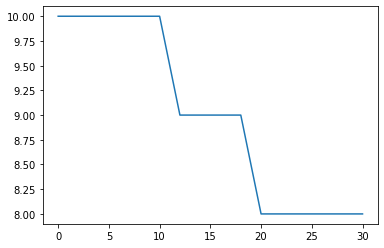

In [50]:
# plot the threshold vs the number of selected features
pyplot.plot(thresholds, results)
pyplot.show()

### 2.2. Valores duplicados

#### 2.2.1. Identificación de filas con valores duplicados

Veamos el número de registros duplicados (contando la variable `'Orden1'`) que existen en nuestro dataset.

In [51]:
# locate rows of duplicate data
# All rows are marked as either False to indicate that it is not a duplicate or True to indicate that it is a duplicate.
dups = df.duplicated()
# report if there are any duplicates
print(dups.any())
# list all duplicate rows
print(df[dups].shape[0])

True
58


#### 2.2.2. Borrado de filas con valores duplicados

Eliminemos de todos los datasets los registros duplicados de cada uno. Vemos que en cada uno se identifica un número diferente. Concretamente, cuantas menos columnas hayamos dejado, más posiblidades hay de que haya duplicados. Podríamos reflexionar que, quizá, al tratarse de registros que no estaban duplicados en el dataset original (quizá se correspondían con especímenes de sexos diferentes, o medidos por entidades distintas) deberíamos dejarlos. No obstante, como las dos únicas variables que hemos eliminado son `'Sex'`  y `'Measurer'` y ninguna de las dos es realmente importante para las distribuciones del problema, vamos a eliminarlos normalmente.

In [52]:
# delete rows of duplicate data from the dataset
print(df.shape)
df.drop_duplicates(inplace=True)
print(df.shape)

(7343, 13)
(7285, 13)


In [53]:
# delete rows of duplicate data from the dataset
print(df_noFewValuesColumns.shape)
df_noFewValuesColumns.drop_duplicates(inplace=True)
print(df_noFewValuesColumns.shape)

(7343, 12)
(7282, 12)


In [54]:
# delete rows of duplicate data from the dataset
print(df_withoutMeasurer.shape)
df_withoutMeasurer.drop_duplicates(inplace=True)
print(df_withoutMeasurer.shape)

(7343, 12)
(7280, 12)


In [55]:
# delete rows of duplicate data from the dataset
print(df_withoutMeasurer_noFewValuesColumns.shape)
df_withoutMeasurer_noFewValuesColumns.drop_duplicates(inplace=True)
print(df_withoutMeasurer_noFewValuesColumns.shape)

(7343, 11)
(7278, 11)


### 2.3. Valores nulos

#### 2.3.1. Identificación de valores nulos

Mostremos primeramente la cantidad de nulos que existen en cada columna del dataset.

In [56]:
# count the number of zero values for each column
num_nulls = (df.isnull()).sum()
# report the results
print(num_nulls)

Order1                   0
Sex                      0
Beak.Length_Culmen      96
Beak.Length_Nares     3785
Beak.Width             723
Beak.Depth             410
Tarsus.Length          663
Wing.Length             22
Kipps.Distance        2549
Secondary1            2543
Hand-wing.Index       2550
Tail.Length            113
Measurer                 0
dtype: int64


Vemos que hay una gran cantidad de nulos, y si mostramos los porcentajes vemos que en varias columnas se alcanza el 35%, en la que más un 52%. Podríamos pensar en eliminar esas columnas, pero son influyentes en el resultado. Concretamente `'Beak.Length_Nares'` indica una de las características básicas de los picos de los pájaros. Los Piciformes (una de las dos clases que queremos identificar) tienen ese nombre por la forma del pico (Pici-formes). Si eliminásemos esa variable, perderíamos mucha información que podría ser básica para identificar esta segunda clase, por lo que no lo haremos.

In [57]:
# summarize the number of rows with missing values for each column
for i in range(df.shape[1]):
    # count number of rows with missing values
    n_miss = df.iloc[:,i].isnull().sum()
    perc = n_miss / df.shape[0] * 100
    print('> %d \t Missing: %d \t (%.1f%%) \t %s' % (i, n_miss, perc, df.columns[i]))

> 0 	 Missing: 0 	 (0.0%) 	 Order1tr
> 1 	 Missing: 0 	 (0.0%) 	 Sextr
> 2 	 Missing: 96 	 (1.3%) 	 Beak.Length_Culmentr
> 3 	 Missing: 3785 	 (52.0%) 	 Beak.Length_Narestr
> 4 	 Missing: 723 	 (9.9%) 	 Beak.Widthtr
> 5 	 Missing: 410 	 (5.6%) 	 Beak.Depthtr
> 6 	 Missing: 663 	 (9.1%) 	 Tarsus.Lengthtr
> 7 	 Missing: 22 	 (0.3%) 	 Wing.Lengthtr
> 8 	 Missing: 2549 	 (35.0%) 	 Kipps.Distancetr
> 9 	 Missing: 2543 	 (34.9%) 	 Secondary1tr
> 10 	 Missing: 2550 	 (35.0%) 	 Hand-wing.Indextr
> 11 	 Missing: 113 	 (1.6%) 	 Tail.Lengthtr
> 12 	 Missing: 0 	 (0.0%) 	 Measurertr


Aunque sabemos que los nulos del archivo CSV original estaban codificados mediante 'NA', conviene estudiar el número de ceros de cada variable, ya que podríamos encontrar comportamientos anómalos respecto de la definición de cada una.

In [58]:
# count the number of zero values for each column
num_zeros = (df[:] == 0).sum()
# report the results
print(num_zeros)

Order1                0
Sex                   0
Beak.Length_Culmen    0
Beak.Length_Nares     0
Beak.Width            0
Beak.Depth            0
Tarsus.Length         0
Wing.Length           0
Kipps.Distance        0
Secondary1            0
Hand-wing.Index       0
Tail.Length           0
Measurer              0
dtype: int64


Vemos que no hay. Esto tiene sentido, ya que hablamos de medidas reales de los especímenes.

#### 2.3.2. Soluciones al prolema de valores nulos

Declaramos inicialmente los modelos con los que vamos a probar nuestros preprocesados. Para nuestras pruebas, trabajaremos con clasificadores MLP, SVM y Random Forest.

In [59]:
models = [MLPClassifier(random_state=123, max_iter=300),
          SVC(),
          RandomForestClassifier(random_state=123)]
names =  ["Multi-layer Perceptron Classifier",
          "Support Vector Machine Classifier", 
          "Random Forest Classifier"]

A continuación, dividimos en *X* e *y* los cuatro dataframes de partida que hemos configurado en los apartados anteriores.

In [60]:
# split data into inputs and outputs
X = df.iloc[:, 1:]
X_noFewValuesColumns = df_noFewValuesColumns.iloc[:, 1:]
X_withoutMeasurer = df_withoutMeasurer.iloc[:, 1:]
X_withoutMeasurer_noFewValuesColumns = df_withoutMeasurer_noFewValuesColumns.iloc[:, 1:]

y = df.iloc[:, 0]
y_noFewValuesColumns = df_noFewValuesColumns.iloc[:, 0]
y_withoutMeasurer = df_withoutMeasurer.iloc[:, 0]
y_withoutMeasurer_noFewValuesColumns = df_withoutMeasurer_noFewValuesColumns.iloc[:, 0]

print(X.shape, y.shape)
print(X_noFewValuesColumns.shape, y_noFewValuesColumns.shape)
print(X_withoutMeasurer.shape, y_withoutMeasurer.shape)
print(X_withoutMeasurer_noFewValuesColumns.shape, y_withoutMeasurer_noFewValuesColumns.shape)

(7285, 12) (7285,)
(7282, 11) (7282,)
(7280, 11) (7280,)
(7278, 10) (7278,)


##### 2.3.3.1. Borrado de filas con valores nulos

Podemos pensar en la opción de borrar todos los registros del dataset con nulos. Como hemos visto, en varias variables esta cantidad supera el 30%, llegando hasta el 50%. Esto haría que se redujera en exceso el dataset. Aun así, vamos a extraer estos conjuntos de datos filtrados para hacer las pruebas futuras.

In [61]:
# drop rows with missing values
df_noNulls = df.copy()
df_noFewValuesColumns_noNulls = df_noFewValuesColumns.copy()
df_withoutMeasurer_noNulls = df_withoutMeasurer.copy()
df_withoutMeasurer_noFewValuesColumns_noNulls = df_withoutMeasurer_noFewValuesColumns.copy()

df_noNulls.dropna(inplace=True)
df_noFewValuesColumns_noNulls.dropna(inplace=True)
df_withoutMeasurer_noNulls.dropna(inplace=True)
df_withoutMeasurer_noFewValuesColumns_noNulls.dropna(inplace=True)

#Before
print(df.shape)
print(df_noFewValuesColumns.shape)
print(df_withoutMeasurer.shape)
print(df_withoutMeasurer_noFewValuesColumns.shape)

#After
print(df_noNulls.shape)
print(df_noFewValuesColumns_noNulls.shape)
print(df_withoutMeasurer_noNulls.shape)
print(df_withoutMeasurer_noFewValuesColumns_noNulls.shape)

(7285, 13)
(7282, 12)
(7280, 12)
(7278, 11)
(3411, 13)
(3411, 12)
(3410, 12)
(3410, 11)


In [62]:
# split data into inputs and outputs
X_noNulls = df_noNulls.iloc[:, 1:]
X_noFewValuesColumns_noNulls = df_noFewValuesColumns_noNulls.iloc[:, 1:]
X_withoutMeasurer_noNulls = df_withoutMeasurer_noNulls.iloc[:, 1:]
X_withoutMeasurer_noFewValuesColumns_noNulls = df_withoutMeasurer_noFewValuesColumns_noNulls.iloc[:, 1:]

y_noNulls = df_noNulls.iloc[:, 0]
y_withoutMeasurer_noNulls = df_withoutMeasurer_noNulls.iloc[:, 0]

print(X_noNulls.shape, y_noNulls.shape)
print(X_noFewValuesColumns_noNulls.shape, y_noNulls.shape)
print(X_withoutMeasurer_noNulls.shape, y_withoutMeasurer_noNulls.shape)
print(X_withoutMeasurer_noFewValuesColumns_noNulls.shape, y_withoutMeasurer_noNulls.shape)

(3411, 12) (3411,)
(3411, 11) (3411,)
(3410, 11) (3410,)
(3410, 10) (3410,)


Para obtener la colección de resultados para esta técnica y las posteriores de imputación de nulos, vamos a crear un DataFrame que almacene la accuracy de cada modelo con cada técnica y estrategia.

In [63]:
results = pd.DataFrame(columns=['Dataset', 'Model', 'Imputation', 'Strategy', 'Scores (Mean)', 'Scores (SD)'])

Antes de poder aplicar cada uno de los tres modelos al dataset, debemos codificar la variable objetivo y aplicar una codificación OneHot al sexo y a la entidad medidora. Extraemos este proceso en una función aparte.

In [64]:
def preparado_nulos(X, y, cat_cols):
    le = LabelEncoder()
    y_prov = le.fit_transform(y)

    ohe = OneHotEncoder(handle_unknown='ignore')

    encoded_X_prov = ohe.fit_transform(X.loc[:,cat_cols])
    encoded_df_X_prov = pd.DataFrame(encoded_X_prov.toarray(), columns=ohe.get_feature_names_out(), index=X.index)
    X_prov = pd.concat([X, encoded_df_X_prov], axis=1)
    X_prov.drop(cat_cols, axis=1, inplace=True)
    
    return X_prov, y_prov, le, ohe

OPbtenemos los resultados para los distintos datasets.

In [65]:
%%time

cat_cols = ['Sex', 'Measurer']
X_prov, y_prov, le, ohe = preparado_nulos(X_noNulls, y_noNulls, cat_cols)

for i, model in enumerate(models):
    # evaluate the model
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X_prov, y_prov, scoring='accuracy', cv=cv, n_jobs=-1)  #array
    # store results
    results.loc[len(results.index)] = {'Dataset': "Base", 
                    'Model': names[i], 
                    'Imputation': "Deleting null rows", 
                    'Strategy': np.NaN, 
                    'Scores (Mean)': np.mean(scores), 
                    'Scores (SD)': np.std(scores)}
    print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores)))

>Multi-layer Perceptron Classifier 0.994 (0.003)
>Support Vector Machine Classifier 0.969 (0.003)
>Random Forest Classifier 0.990 (0.005)
CPU times: total: 219 ms
Wall time: 9.63 s


In [66]:
%%time

cat_cols = ['Measurer']
X_prov, y_prov, le, ohe = preparado_nulos(X_noFewValuesColumns_noNulls, y_noNulls, cat_cols)

for i, model in enumerate(models):
    # evaluate the model
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X_prov, y_prov, scoring='accuracy', cv=cv, n_jobs=-1)  #array
    # store results
    results.loc[len(results.index)] = {'Dataset': "No-few-values-columns", 
                    'Model': names[i], 
                    'Imputation': "Deleting null rows", 
                    'Strategy': np.NaN, 
                    'Scores (Mean)': np.mean(scores), 
                    'Scores (SD)': np.std(scores)}
    print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores)))

>Multi-layer Perceptron Classifier 0.994 (0.004)
>Support Vector Machine Classifier 0.969 (0.003)
>Random Forest Classifier 0.990 (0.005)
CPU times: total: 141 ms
Wall time: 5.93 s


In [67]:
%%time

cat_cols = ['Sex']
X_prov, y_prov, le, ohe = preparado_nulos(X_withoutMeasurer_noNulls, y_withoutMeasurer_noNulls, cat_cols)

for i, model in enumerate(models):
    # evaluate the model
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X_prov, y_prov, scoring='accuracy', cv=cv, n_jobs=-1)  #array
    # store results
    results.loc[len(results.index)] = {'Dataset': "No-measurer", 
                    'Model': names[i], 
                    'Imputation': "Deleting null rows", 
                    'Strategy': np.NaN, 
                    'Scores (Mean)': np.mean(scores), 
                    'Scores (SD)': np.std(scores)}
    print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores)))

>Multi-layer Perceptron Classifier 0.985 (0.006)
>Support Vector Machine Classifier 0.970 (0.004)
>Random Forest Classifier 0.980 (0.005)
CPU times: total: 125 ms
Wall time: 3.73 s


In [68]:
%%time

cat_cols = []
X_prov, y_prov, le, ohe = preparado_nulos(X_withoutMeasurer_noFewValuesColumns_noNulls, y_withoutMeasurer_noNulls, cat_cols)

for i, model in enumerate(models):
    # evaluate the model
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X_withoutMeasurer_noFewValuesColumns_noNulls, y_prov, scoring='accuracy', cv=cv, n_jobs=-1)  #array
    # store results
    results.loc[len(results.index)] = {'Dataset': "No-measurer-no-few-values-columns", 
                    'Model': names[i], 
                    'Imputation': "Deleting null rows", 
                    'Strategy': np.NaN, 
                    'Scores (Mean)': np.mean(scores), 
                    'Scores (SD)': np.std(scores)}
    print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores)))

>Multi-layer Perceptron Classifier 0.983 (0.005)
>Support Vector Machine Classifier 0.970 (0.004)
>Random Forest Classifier 0.981 (0.005)
CPU times: total: 109 ms
Wall time: 3.49 s


Utilizar el dataset con información sobre la entidad de medición aumenta en muy gran medida la precisión de nuestros modelos, llegando a alcanzar un 98'4%. Esto puede deberse a que cada entidad podría especializarse en un tipo de aves concreto.

Debemos decidir si continuar con esta información en nuestro dataset o no. Puesto que la intención del trabajo es poder clasificar aves independientemente de la entidad que envíe los datos, continuaremos con los datasets que ignoran estas características (`df_withoutMeasurer` y `df_noFewValuesColumns_withoutMeasurer`). Por comodidad, vamos a "renombrar" las variables.

In [69]:
df = df_withoutMeasurer
df_noFewValuesColumns = df_withoutMeasurer_noFewValuesColumns

X = X_withoutMeasurer
X_noFewValuesColumns = X_withoutMeasurer_noFewValuesColumns

y = y_withoutMeasurer
y_noFewValuesColumns = y_withoutMeasurer_noFewValuesColumns

Por último, podemos ver que el dataset que ignora el campo `Sex` obtiene mejores resultados.

##### 2.3.3.2. Imputación estadística

Probemos ahora otros tipos de imputaciones: las estadísticas, la iterativa y por KNN. Obtenemos del mismo modo los resultados para los tres datasets con estos métodos.

Primero, probamos la imputación estadística utilizando la media, la mediana, la moda y una constante.

In [70]:
%%time

# evaluate each strategy on base dataset
strategies = ['mean', 'median', 'most_frequent', 'constant']

cat_cols = ['Sex']
X_prov, y_prov, le, ohe = preparado_nulos(X, y, cat_cols)

for i, model in enumerate(models):
    for s in strategies:
        # create the modeling pipeline
        pipeline = Pipeline(steps=[('i', SimpleImputer(strategy=s)), ('m', model)])
        # evaluate the model
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        scores = cross_val_score(pipeline, X_prov, y_prov, scoring='accuracy', cv=cv, n_jobs=-1)  #array
        # store results
        results.loc[len(results.index)] = {'Dataset': "Base", 
                        'Model': names[i], 
                        'Imputation': "Simple Imputation", 
                        'Strategy': s, 
                        'Scores (Mean)': np.mean(scores), 
                        'Scores (SD)': np.std(scores)}
        print('>%s, %s %.3f (%.3f)' % (names[i], s, np.mean(scores), np.std(scores)))
    print()

>Multi-layer Perceptron Classifier, mean 0.977 (0.004)
>Multi-layer Perceptron Classifier, median 0.978 (0.004)
>Multi-layer Perceptron Classifier, most_frequent 0.978 (0.005)
>Multi-layer Perceptron Classifier, constant 0.980 (0.005)

>Support Vector Machine Classifier, mean 0.970 (0.002)
>Support Vector Machine Classifier, median 0.970 (0.002)
>Support Vector Machine Classifier, most_frequent 0.971 (0.002)
>Support Vector Machine Classifier, constant 0.970 (0.002)

>Random Forest Classifier, mean 0.981 (0.003)
>Random Forest Classifier, median 0.981 (0.003)
>Random Forest Classifier, most_frequent 0.980 (0.004)
>Random Forest Classifier, constant 0.980 (0.003)

CPU times: total: 922 ms
Wall time: 31.4 s


In [71]:
%%time

# evaluate each strategy on "no-few-values-columns" dataset
strategies = ['mean', 'median', 'most_frequent', 'constant']  

cat_cols = []
X_prov, y_prov, le, ohe = preparado_nulos(X_noFewValuesColumns, y_noFewValuesColumns, cat_cols)

for i, model in enumerate(models):
    for s in strategies:
        # create the modeling pipeline
        pipeline = Pipeline(steps=[('i', SimpleImputer(strategy=s)), ('m', model)])
        # evaluate the model
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        scores = cross_val_score(pipeline, X_prov, y_prov, scoring='accuracy', cv=cv, n_jobs=-1)  #array
        # store results
        results.loc[len(results.index)] = {'Dataset': "No-few-values-columns", 
                        'Model': names[i], 
                        'Imputation': "Simple Imputation", 
                        'Strategy': s, 
                        'Scores (Mean)': np.mean(scores), 
                        'Scores (SD)': np.std(scores)}
        print('>%s, %s %.3f (%.3f)' % (names[i], s, np.mean(scores), np.std(scores)))
    print()

>Multi-layer Perceptron Classifier, mean 0.975 (0.004)
>Multi-layer Perceptron Classifier, median 0.976 (0.005)
>Multi-layer Perceptron Classifier, most_frequent 0.977 (0.005)
>Multi-layer Perceptron Classifier, constant 0.980 (0.005)

>Support Vector Machine Classifier, mean 0.971 (0.002)
>Support Vector Machine Classifier, median 0.971 (0.002)
>Support Vector Machine Classifier, most_frequent 0.971 (0.002)
>Support Vector Machine Classifier, constant 0.970 (0.002)

>Random Forest Classifier, mean 0.982 (0.004)
>Random Forest Classifier, median 0.982 (0.004)
>Random Forest Classifier, most_frequent 0.982 (0.004)
>Random Forest Classifier, constant 0.981 (0.004)

CPU times: total: 797 ms
Wall time: 30.7 s


##### 2.3.3.3. Imputación iterativa

Ahora, probamos a emplear una Iterative Imputation mediante las estrategias ascendente, descendente, por orden romano, por orden arábigo o aleatoriamente.

In [72]:
%%time

# evaluate each strategy on base dataset
strategies = ['ascending', 'descending', 'roman', 'arabic', 'random']

cat_cols = ['Sex']
X_prov, y_prov, le, ohe = preparado_nulos(X, y, cat_cols)

for i, model in enumerate(models):
    for s in strategies:
        imputers = [IterativeImputer(estimator=linear_model.Lasso(alpha=0.1), n_nearest_features=None,imputation_order=s),
                    IterativeImputer(estimator=linear_model.LassoLars(), n_nearest_features=None,imputation_order=s),
                    IterativeImputer(estimator=linear_model.BayesianRidge(), n_nearest_features=None,imputation_order=s)]
        imputersnames = ["Iterative Imputer (Lasso Estimator)",
                         "Iterative Imputer (LassoLars Estimator)",
                         "Iterative Imputer (BayesianRidge Estimator)"]
        for ii, iimputers in enumerate(imputers):
            # create the modeling pipeline
            pipeline = Pipeline(steps=[('i', iimputers), ('m', model)])
            # evaluate the model
            cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
            scores = cross_val_score(pipeline, X_prov, y_prov, scoring='accuracy', cv=cv, n_jobs=-1)
            # store results
            results.loc[len(results.index)] = {'Dataset': "Base", 
                            'Model': names[i], 
                            'Imputation': imputersnames[ii], 
                            'Strategy': s, 
                            'Scores (Mean)': np.mean(scores), 
                            'Scores (SD)': np.std(scores)}
            print('>%s, %s %s %.3f (%.3f)' % (names[i], imputersnames[ii], s, np.mean(scores), np.std(scores)))
        print()
    print("--------------------------------------------------------------------")
    print()

>Multi-layer Perceptron Classifier, Iterative Imputer (Lasso Estimator) ascending 0.980 (0.007)
>Multi-layer Perceptron Classifier, Iterative Imputer (LassoLars Estimator) ascending 0.977 (0.004)
>Multi-layer Perceptron Classifier, Iterative Imputer (BayesianRidge Estimator) ascending 0.981 (0.004)

>Multi-layer Perceptron Classifier, Iterative Imputer (Lasso Estimator) descending 0.981 (0.005)
>Multi-layer Perceptron Classifier, Iterative Imputer (LassoLars Estimator) descending 0.977 (0.004)
>Multi-layer Perceptron Classifier, Iterative Imputer (BayesianRidge Estimator) descending 0.980 (0.004)

>Multi-layer Perceptron Classifier, Iterative Imputer (Lasso Estimator) roman 0.979 (0.004)
>Multi-layer Perceptron Classifier, Iterative Imputer (LassoLars Estimator) roman 0.977 (0.004)
>Multi-layer Perceptron Classifier, Iterative Imputer (BayesianRidge Estimator) roman 0.981 (0.004)

>Multi-layer Perceptron Classifier, Iterative Imputer (Lasso Estimator) arabic 0.980 (0.004)
>Multi-layer 

In [73]:
%%time

# evaluate each strategy on "no-few-values-columns" dataset
strategies = ['ascending', 'descending', 'roman', 'arabic', 'random']

cat_cols = []
X_prov, y_prov, le, ohe = preparado_nulos(X_noFewValuesColumns, y_noFewValuesColumns, cat_cols)

for i, model in enumerate(models):
    for s in strategies:
        imputers = [IterativeImputer(estimator=linear_model.Lasso(alpha=0.1), n_nearest_features=None,imputation_order=s),
                    IterativeImputer(estimator=linear_model.LassoLars(), n_nearest_features=None,imputation_order=s),
                    IterativeImputer(estimator=linear_model.BayesianRidge(), n_nearest_features=None,imputation_order=s)]
        imputersnames = ["Iterative Imputer (Lasso Estimator)",
                         "Iterative Imputer (LassoLars Estimator)",
                         "Iterative Imputer (BayesianRidge Estimator)"]
        for ii, iimputers in enumerate(imputers):
            # create the modeling pipeline
            pipeline = Pipeline(steps=[('i', iimputers), ('m', model)])
            # evaluate the model
            cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
            scores = cross_val_score(pipeline, X_prov, y_prov, scoring='accuracy', cv=cv, n_jobs=-1)
            # store results
            results.loc[len(results.index)] = {'Dataset': "No-few-values-columns", 
                            'Model': names[i], 
                            'Imputation': imputersnames[ii], 
                            'Strategy': s, 
                            'Scores (Mean)': np.mean(scores), 
                            'Scores (SD)': np.std(scores)}
            print('>%s, %s %s %.3f (%.3f)' % (names[i], imputersnames[ii], s, np.mean(scores), np.std(scores)))
        print()
    print("--------------------------------------------------------------------")
    print()

>Multi-layer Perceptron Classifier, Iterative Imputer (Lasso Estimator) ascending 0.980 (0.004)
>Multi-layer Perceptron Classifier, Iterative Imputer (LassoLars Estimator) ascending 0.975 (0.004)
>Multi-layer Perceptron Classifier, Iterative Imputer (BayesianRidge Estimator) ascending 0.979 (0.004)

>Multi-layer Perceptron Classifier, Iterative Imputer (Lasso Estimator) descending 0.979 (0.003)
>Multi-layer Perceptron Classifier, Iterative Imputer (LassoLars Estimator) descending 0.975 (0.004)
>Multi-layer Perceptron Classifier, Iterative Imputer (BayesianRidge Estimator) descending 0.979 (0.004)

>Multi-layer Perceptron Classifier, Iterative Imputer (Lasso Estimator) roman 0.979 (0.005)
>Multi-layer Perceptron Classifier, Iterative Imputer (LassoLars Estimator) roman 0.975 (0.004)
>Multi-layer Perceptron Classifier, Iterative Imputer (BayesianRidge Estimator) roman 0.978 (0.005)

>Multi-layer Perceptron Classifier, Iterative Imputer (Lasso Estimator) arabic 0.980 (0.004)
>Multi-layer 

##### 2.3.3.4. Imputación por KNN

Para llevar a cabo la imputación por KNN, utilizamos enteros entre el 1 y el 21 (por cuestiones de rapidez lo probaremos con saltos de 2) como parámetro *N*.

In [74]:
%%time

# evaluate each strategy on base dataset
strategies = [i for i in range(1,22,2)]

cat_cols = ['Sex']
X_prov, y_prov, le, ohe = preparado_nulos(X, y, cat_cols)

for i, model in enumerate(models):
    for s in strategies:
        # create the modeling pipeline
        pipeline = Pipeline(steps=[('i', KNNImputer(n_neighbors=s)), ('m', model)])
        # evaluate the model
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        scores = cross_val_score(pipeline, X_prov, y_prov, scoring='accuracy', cv=cv, n_jobs=-1)
        # store results
        results.loc[len(results.index)] = {'Dataset': "Base", 
                        'Model': names[i], 
                        'Imputation': "KNN Imputer", 
                        'Strategy': s, 
                        'Scores (Mean)': np.mean(scores), 
                        'Scores (SD)': np.std(scores)}
        print('>%s, %s %.3f (%.3f)' % (names[i], s, np.mean(scores), np.std(scores)))
    print()

>Multi-layer Perceptron Classifier, 1 0.978 (0.006)
>Multi-layer Perceptron Classifier, 3 0.981 (0.004)
>Multi-layer Perceptron Classifier, 5 0.980 (0.007)
>Multi-layer Perceptron Classifier, 7 0.981 (0.005)
>Multi-layer Perceptron Classifier, 9 0.981 (0.004)
>Multi-layer Perceptron Classifier, 11 0.981 (0.005)
>Multi-layer Perceptron Classifier, 13 0.981 (0.005)
>Multi-layer Perceptron Classifier, 15 0.981 (0.005)
>Multi-layer Perceptron Classifier, 17 0.981 (0.004)
>Multi-layer Perceptron Classifier, 19 0.981 (0.005)
>Multi-layer Perceptron Classifier, 21 0.981 (0.004)

>Support Vector Machine Classifier, 1 0.971 (0.002)
>Support Vector Machine Classifier, 3 0.972 (0.002)
>Support Vector Machine Classifier, 5 0.971 (0.002)
>Support Vector Machine Classifier, 7 0.972 (0.002)
>Support Vector Machine Classifier, 9 0.971 (0.002)
>Support Vector Machine Classifier, 11 0.972 (0.002)
>Support Vector Machine Classifier, 13 0.971 (0.002)
>Support Vector Machine Classifier, 15 0.972 (0.002)
>S

In [75]:
%%time

# evaluate each strategy on "no-few-values-columns" dataset
strategies = [i for i in range(1,22,2)]

cat_cols = []
X_prov, y_prov, le, ohe = preparado_nulos(X_noFewValuesColumns, y_noFewValuesColumns, cat_cols)

for i, model in enumerate(models):
    for s in strategies:
        # create the modeling pipeline
        pipeline = Pipeline(steps=[('i', KNNImputer(n_neighbors=s)), ('m', model)])
        # evaluate the model
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        scores = cross_val_score(pipeline, X_prov, y_prov, scoring='accuracy', cv=cv, n_jobs=-1)
        # store results
        results.loc[len(results.index)] = {'Dataset': "No-few-values-columns", 
                        'Model': names[i], 
                        'Imputation': "KNN Imputer", 
                        'Strategy': s, 
                        'Scores (Mean)': np.mean(scores), 
                        'Scores (SD)': np.std(scores)}
        print('>%s, %s %.3f (%.3f)' % (names[i], s, np.mean(scores), np.std(scores)))
    print()

>Multi-layer Perceptron Classifier, 1 0.979 (0.003)
>Multi-layer Perceptron Classifier, 3 0.980 (0.005)
>Multi-layer Perceptron Classifier, 5 0.979 (0.007)
>Multi-layer Perceptron Classifier, 7 0.977 (0.005)
>Multi-layer Perceptron Classifier, 9 0.979 (0.004)
>Multi-layer Perceptron Classifier, 11 0.978 (0.005)
>Multi-layer Perceptron Classifier, 13 0.977 (0.004)
>Multi-layer Perceptron Classifier, 15 0.978 (0.004)
>Multi-layer Perceptron Classifier, 17 0.978 (0.005)
>Multi-layer Perceptron Classifier, 19 0.977 (0.004)
>Multi-layer Perceptron Classifier, 21 0.978 (0.004)

>Support Vector Machine Classifier, 1 0.972 (0.002)
>Support Vector Machine Classifier, 3 0.972 (0.002)
>Support Vector Machine Classifier, 5 0.972 (0.002)
>Support Vector Machine Classifier, 7 0.971 (0.002)
>Support Vector Machine Classifier, 9 0.971 (0.002)
>Support Vector Machine Classifier, 11 0.972 (0.002)
>Support Vector Machine Classifier, 13 0.972 (0.002)
>Support Vector Machine Classifier, 15 0.972 (0.002)
>S

Es curioso ver cómo la imputación por KNN utilizando todas las variables tarda menos tiempo (al menos bajo las condiciones en las que he ejecutado la porción de código) y obtiene peores resultados.

##### 2.3.3.5. Resultados

Pasemos a analizar los resultados. Como vemos, disponemos de un total de 192 registros en nuestro dataframe de resultados, con lo que podemos determinar el mejor dataset de partida, el mejor modelo y el mejor algoritmo de imputación.

In [76]:
results.shape

(192, 6)

In [77]:
results.head()

,Dataset,Model,Imputation,Strategy,Scores (Mean),Scores (SD)
0,Base,Multi-layer Perceptron Classifier,Deleting null rows,NaN,0.994136,0.003469
1,Base,Support Vector Machine Classifier,Deleting null rows,NaN,0.969315,0.002804
2,Base,Random Forest Classifier,Deleting null rows,NaN,0.990422,0.005131
3,No-few-values-columns,Multi-layer Perceptron Classifier,Deleting null rows,NaN,0.994136,0.003631
4,No-few-values-columns,Support Vector Machine Classifier,Deleting null rows,NaN,0.969315,0.002804


Vemos que los algoritmos sobre la imputación por eliminación de filas nulas funciona bastante bien. Temo que esto se deba a que los especímenes para los que existen valores nulos se correspondan en mayor medida a una clase de las dos (concretamente a 'PICIFORMES', que es la minoritaria). Aun así, veamos los resultados que obtenemos. En caso de que los mejores scores se correspondan con la técnica de eliminación de filas, haremos una comprobación mediante técnicas de balanceo de datos.

Obtengamos la mejor combinación de dataset y modelo para los resultados obtenidos.

In [78]:
# results[(results['Dataset']!='No-measurer') & (results['Dataset']!='No-measurer-no-few-values-columns')].groupby(['Model', 'Dataset'])[['Scores (Mean)', 'Scores (SD)']].mean()
results[(results['Dataset']!='No-measurer') & (results['Dataset']!='No-measurer-no-few-values-columns')].groupby(['Model', 'Dataset'])[['Scores (Mean)', 'Scores (SD)']].mean().sort_values('Scores (Mean)', ascending=False)

Scores (Mean)  \
Model                             Dataset                                
Random Forest Classifier          No-few-values-columns       0.983207   
                                  Base                        0.982193   
Multi-layer Perceptron Classifier Base                        0.980169   
                                  No-few-values-columns       0.978411   
Support Vector Machine Classifier No-few-values-columns       0.971210   
                                  Base                        0.971151   

                                                         Scores (SD)  
Model                             Dataset                             
Random Forest Classifier          No-few-values-columns     0.003884  
                                  Base                      0.003839  
Multi-layer Perceptron Classifier Base                      0.004561  
                                  No-few-values-columns     0.004464  
Support Vector Machine Classifier No-few-values-columns     0.002262  
                                  Base                      0.002251

Para tres combinaciones seleccionadas por sus buenos resultados, escogemos el método de imputación que mejor comportamiento haya tenido.

In [79]:
# results[(results[['Model', 'Dataset']] == (names[0], 'Base')).all(axis=1)].groupby(['Imputation', 'Strategy'])[['Scores (Mean)', 'Scores (SD)']].mean()
results[(results[['Model', 'Dataset']] == (names[0], 'Base')).all(axis=1)].groupby(['Imputation', 'Strategy'])[['Scores (Mean)', 'Scores (SD)']].mean().sort_values('Scores (Mean)', ascending=False)

Scores (Mean)  \
Imputation                                  Strategy                       
KNN Imputer                                 11                  0.981456   
Iterative Imputer (BayesianRidge Estimator) roman               0.981319   
KNN Imputer                                 3                   0.981227   
                                            9                   0.981181   
Iterative Imputer (Lasso Estimator)         descending          0.981181   
KNN Imputer                                 15                  0.981136   
                                            17                  0.981136   
                                            7                   0.981090   
                                            19                  0.980952   
Iterative Imputer (BayesianRidge Estimator) arabic              0.980952   
                                            ascending           0.980907   
KNN Imputer                                 13                  0.980861   
                                            21                  0.980723   
                                            5                   0.980449   
Iterative Imputer (BayesianRidge Estimator) descending          0.980357   
Iterative Imputer (Lasso Estimator)         arabic              0.980357   
Simple Imputation                           constant            0.980311   
Iterative Imputer (BayesianRidge Estimator) random              0.980266   
Iterative Imputer (Lasso Estimator)         random              0.980174   
                                            ascending           0.979945   
                                            roman               0.979487   
Simple Imputation                           most_frequent       0.978342   
KNN Imputer                                 1                   0.977930   
Simple Imputation                           median              0.977564   
Iterative Imputer (LassoLars Estimator)     roman               0.976969   
                                            random              0.976969   
                                            descending          0.976969   
                                            ascending           0.976969   
                                            arabic              0.976969   
Simple Imputation                           mean                0.976969   

                                                           Scores (SD)  
Imputation                                  Strategy                    
KNN Imputer                                 11                0.004539  
Iterative Imputer (BayesianRidge Estimator) roman             0.004396  
KNN Imputer                                 3                 0.004363  
                                            9                 0.003968  
Iterative Imputer (Lasso Estimator)         descending        0.004891  
KNN Imputer                                 15                0.004569  
                                            17                0.003719  
                                            7                 0.004728  
                                            19                0.004962  
Iterative Imputer (BayesianRidge Estimator) arabic            0.003715  
                                            ascending         0.004246  
KNN Imputer                                 13                0.004623  
                                            21                0.003625  
                                            5                 0.007487  
Iterative Imputer (BayesianRidge Estimator) descending        0.003871  
Iterative Imputer (Lasso Estimator)         arabic            0.003620  
Simple Imputation                           constant          0.004602  
Iterative Imputer (BayesianRidge Estimator) random            0.004725  
Iterative Imputer (Lasso Estimator)         random            0.004281  
                                            ascending         0.006864  
                    

In [80]:
# results[(results[['Model', 'Dataset']] == (names[1], 'No-few-values-columns')).all(axis=1)].groupby(['Imputation', 'Strategy'])[['Scores (Mean)', 'Scores (SD)']].mean()
results[(results[['Model', 'Dataset']] == (names[1], 'No-few-values-columns')).all(axis=1)].groupby(['Imputation', 'Strategy'])[['Scores (Mean)', 'Scores (SD)']].mean().sort_values('Scores (Mean)', ascending=False)

Scores (Mean)  \
Imputation                                  Strategy                       
KNN Imputer                                 1                   0.971696   
Iterative Imputer (BayesianRidge Estimator) ascending           0.971696   
Iterative Imputer (Lasso Estimator)         ascending           0.971696   
                                            arabic              0.971650   
Iterative Imputer (BayesianRidge Estimator) arabic              0.971650   
                                            random              0.971650   
Iterative Imputer (Lasso Estimator)         random              0.971604   
KNN Imputer                                 13                  0.971558   
                                            15                  0.971558   
                                            11                  0.971558   
                                            3                   0.971558   
Iterative Imputer (BayesianRidge Estimator) roman               0.971513   
Iterative Imputer (Lasso Estimator)         descending          0.971513   
                                            roman               0.971513   
Iterative Imputer (BayesianRidge Estimator) descending          0.971513   
KNN Imputer                                 21                  0.971512   
                                            5                   0.971512   
                                            17                  0.971467   
                                            19                  0.971467   
                                            9                   0.971421   
                                            7                   0.971421   
Iterative Imputer (LassoLars Estimator)     roman               0.970642   
                                            random              0.970642   
                                            descending          0.970642   
                                            ascending           0.970642   
                                            arabic              0.970642   
Simple Imputation                           mean                0.970642   
                                            median              0.970597   
                                            most_frequent       0.970597   
                                            constant            0.970413   

                                                           Scores (SD)  
Imputation                                  Strategy                    
KNN Imputer                                 1                 0.002313  
Iterative Imputer (BayesianRidge Estimator) ascending         0.002313  
Iterative Imputer (Lasso Estimator)         ascending         0.002313  
                                            arabic            0.002282  
Iterative Imputer (BayesianRidge Estimator) arabic            0.002282  
                                            random            0.002282  
Iterative Imputer (Lasso Estimator)         random            0.002278  
KNN Imputer                                 13                0.002329  
                                            15                0.002329  
                                            11                0.002329  
                                            3                 0.002191  
Iterative Imputer (BayesianRidge Estimator) roman             0.002348  
Iterative Imputer (Lasso Estimator)         descending        0.002348  
                                            roman             0.002348  
Iterative Imputer (BayesianRidge Estimator) descending        0.002348  
KNN Imputer                                 21                0.002268  
                                            5                 0.002156  
                                            17                0.002233  
                                            19                0.002261  
                                            9                 0.002198  
                    

In [81]:
# results[(results[['Model', 'Dataset']] == (names[2], 'No-few-values-columns')).all(axis=1)].groupby(['Imputation', 'Strategy'])[['Scores (Mean)', 'Scores (SD)']].mean()
results[(results[['Model', 'Dataset']] == (names[2], 'No-few-values-columns')).all(axis=1)].groupby(['Imputation', 'Strategy'])[['Scores (Mean)', 'Scores (SD)']].mean().sort_values('Scores (Mean)', ascending=False)

Scores (Mean)  \
Imputation                                  Strategy                       
Iterative Imputer (Lasso Estimator)         arabic              0.984245   
                                            ascending           0.984108   
Iterative Imputer (BayesianRidge Estimator) arabic              0.984108   
                                            random              0.983924   
KNN Imputer                                 7                   0.983879   
Iterative Imputer (Lasso Estimator)         random              0.983833   
                                            roman               0.983787   
Iterative Imputer (BayesianRidge Estimator) ascending           0.983650   
                                            roman               0.983650   
KNN Imputer                                 1                   0.983604   
Iterative Imputer (BayesianRidge Estimator) descending          0.983512   
Iterative Imputer (Lasso Estimator)         descending          0.983467   
KNN Imputer                                 17                  0.983237   
                                            9                   0.983192   
                                            19                  0.983146   
                                            11                  0.983100   
                                            5                   0.983008   
                                            21                  0.982963   
                                            13                  0.982917   
                                            15                  0.982917   
                                            3                   0.982642   
Simple Imputation                           mean                0.981955   
Iterative Imputer (LassoLars Estimator)     arabic              0.981955   
                                            ascending           0.981955   
                                            roman               0.981955   
                                            random              0.981955   
                                            descending          0.981955   
Simple Imputation                           median              0.981864   
                                            most_frequent       0.981543   
                                            constant            0.981268   

                                                           Scores (SD)  
Imputation                                  Strategy                    
Iterative Imputer (Lasso Estimator)         arabic            0.004115  
                                            ascending         0.004176  
Iterative Imputer (BayesianRidge Estimator) arabic            0.004175  
                                            random            0.003548  
KNN Imputer                                 7                 0.003980  
Iterative Imputer (Lasso Estimator)         random            0.003927  
                                            roman             0.003939  
Iterative Imputer (BayesianRidge Estimator) ascending         0.003889  
                                            roman             0.004141  
KNN Imputer                                 1                 0.003090  
Iterative Imputer (BayesianRidge Estimator) descending        0.003510  
Iterative Imputer (Lasso Estimator)         descending        0.004127  
KNN Imputer                                 17                0.004065  
                                            9                 0.004579  
                                            19                0.004150  
                                            11                0.003888  
                                            5                 0.004158  
                                            21                0.003521  
                                            13                0.003680  
                                            15                0.004085  
                    

Las combinaciones que elegiré serán las 3 siguientes (variadas, de alta precisión media y baja varianza):

* Dataset básico con una KNN Imputation con k=11, con un modelo de clasificación Multi-layer Perceptron (98,15%).
* Dataset sin columnas con baja variedad de valores (`'Sex'`) con una Iterative Imputation con estimador Bayesian Ridge y estrategia ascending, con un modelo de clasificación Support Vector Machine (97,17%).
* Dataset sin columnas con baja variedad de valores (`'Sex'`) con una Iterative Imputation con estimador Lasso y estrategia arabic, con un modelo de clasificación Random Forest (98,42%).

In [82]:
cat_cols = ['Sex']
X_prov, y_prov, le, ohe = preparado_nulos(X, y, cat_cols)

i = KNNImputer(n_neighbors=11)
X_1 = pd.DataFrame(i.fit_transform(X_prov, y_prov), columns=X_prov.columns, index=X_prov.index)
y_1 = y_prov

X_1

,Beak.Length_Culmen,Beak.Length_Nares,Beak.Width,Beak.Depth,Tarsus.Length,Wing.Length,Kipps.Distance,Secondary1,Hand-wing.Index,Tail.Length,Sex_F,Sex_M,Sex_U
0,8.8,4.500000,2.7,2.5,16.8,48.0,8.400000,39.600000,17.500000,48.0,0.0,1.0,0.0
1,9.1,6.727273,2.5,2.0,17.1,51.0,7.709091,43.945455,14.890909,45.0,0.0,1.0,0.0
2,28.7,14.600000,4.2,5.8,25.7,115.0,22.854545,93.100000,19.736364,115.0,0.0,1.0,0.0
3,26.5,12.500000,3.8,5.2,25.3,115.0,25.900000,89.100000,22.500000,114.0,0.0,1.0,0.0
4,14.3,8.163636,4.0,5.7,21.0,65.0,9.418182,55.345455,14.509091,63.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7338,16.5,9.627273,3.6,4.3,22.3,70.0,11.345455,59.045455,16.118182,54.0,0.0,1.0,0.0
7339,13.7,8.500000,2.9,3.9,16.7,58.0,6.500000,51.500000,11.200000,55.0,0.0,1.0,0.0
7340,14.5,8.281818,3.3,4.0,16.0,59.0,8.709091,50.009091,14.809091,60.0,0.0,1.0,0.0
7341,18.4,9.800000,3.6,4.2,22.6,65.0,10.700000,54.300000,16.500000,56.0,0.0,1.0,0.0


In [83]:
cat_cols = []
X_prov, y_prov, le, ohe = preparado_nulos(X_noFewValuesColumns, y_noFewValuesColumns, cat_cols)

i = IterativeImputer(estimator=linear_model.BayesianRidge(), 
                     n_nearest_features=None, 
                     imputation_order='ascending', 
                     max_iter=100)
X_2 = pd.DataFrame(i.fit_transform(X_prov, y_prov), columns=X_prov.columns, index=X_prov.index)
y_2 = y_prov

X_2

,Beak.Length_Culmen,Beak.Length_Nares,Beak.Width,Beak.Depth,Tarsus.Length,Wing.Length,Kipps.Distance,Secondary1,Hand-wing.Index,Tail.Length
0,8.8,4.500000,2.7,2.5,16.8,48.0,8.400000,39.600000,17.500000,48.0
1,9.1,4.494014,2.5,2.0,17.1,51.0,21.884451,29.117487,27.008660,45.0
2,28.7,17.421586,4.2,5.8,25.7,115.0,22.090961,92.910743,18.833165,115.0
3,26.5,12.500000,3.8,5.2,25.3,115.0,25.900000,89.100000,22.500000,114.0
4,14.3,8.779149,4.0,5.7,21.0,65.0,21.903689,43.099941,24.015727,63.0
...,...,...,...,...,...,...,...,...,...,...
7338,16.5,9.860651,3.6,4.3,22.3,70.0,21.922710,48.079323,23.474603,54.0
7339,13.7,8.500000,2.9,3.9,16.7,58.0,6.500000,51.500000,11.200000,55.0
7340,14.5,9.127123,3.3,4.0,16.0,59.0,21.921571,37.081887,26.208220,60.0
7341,18.4,9.800000,3.6,4.2,22.6,65.0,10.700000,54.300000,16.500000,56.0


In [84]:
cat_cols = []
X_prov, y_prov, le, ohe = preparado_nulos(X_noFewValuesColumns, y_noFewValuesColumns, cat_cols)

i = IterativeImputer(estimator=linear_model.Lasso(alpha=0.1), 
                     n_nearest_features=None, 
                     imputation_order='arabic', 
                     max_iter=10000, 
                     tol=0.1)
X_3 = pd.DataFrame(i.fit_transform(X_prov, y_prov), columns=X_prov.columns, index=X_prov.index)
y_3 = y_prov

X_3

,Beak.Length_Culmen,Beak.Length_Nares,Beak.Width,Beak.Depth,Tarsus.Length,Wing.Length,Kipps.Distance,Secondary1,Hand-wing.Index,Tail.Length
0,8.8,4.500000,2.7,2.5,16.8,48.0,8.400000,39.600000,17.500000,48.0
1,9.1,4.370245,2.5,2.0,17.1,51.0,21.677005,29.292747,26.930820,45.0
2,28.7,17.536309,4.2,5.8,25.7,115.0,22.125140,92.885528,18.871368,115.0
3,26.5,12.500000,3.8,5.2,25.3,115.0,25.900000,89.100000,22.500000,114.0
4,14.3,8.644847,4.0,5.7,21.0,65.0,21.746917,43.228485,24.249373,63.0
...,...,...,...,...,...,...,...,...,...,...
7338,16.5,9.773028,3.6,4.3,22.3,70.0,21.789391,48.190688,23.529636,54.0
7339,13.7,8.500000,2.9,3.9,16.7,58.0,6.500000,51.500000,11.200000,55.0
7340,14.5,9.019731,3.3,4.0,16.0,59.0,21.735155,37.240246,26.319316,60.0
7341,18.4,9.800000,3.6,4.2,22.6,65.0,10.700000,54.300000,16.500000,56.0


Incluso con un nivel tan alto de tolerancia, nos indica problemas de convergencia. A priori, podríamos pensar que es culpa del escalado los datos, pero si probamos a aplicar un `MinMaxScaler` o un `StandardScaler` previo nos indica el mismo warning:

In [85]:
# cat_cols = []
# X_prov, y_prov, le, ohe = preparado_nulos(X_noFewValuesColumns, y_noFewValuesColumns, cat_cols)

# i = IterativeImputer(estimator=linear_model.Lasso(alpha=0.1), 
#                      n_nearest_features=None, 
#                      imputation_order='arabic', 
#                      max_iter=10000, 
#                      tol=0.1)

# pip = Pipeline(steps=[('scal', MinMaxScaler()),('imputer', i)])

# X_3 = pd.DataFrame(i.fit_transform(X_prov, y_prov), columns=X_prov.columns, index=X_prov.index)
# y_3 = y_prov

# X_3

### 2.4. Outliers

#### 2.4.1. Borrado de outliers mediante el Standard Deviation Method

Para poder aplicar el SDM, necesitamos que las variables sigan una distribución normal. Si representamos los datos, vemos que la variable `'Hand-wing.Index'` es la única que podríamos considerar que tiene un comportamiento normal.

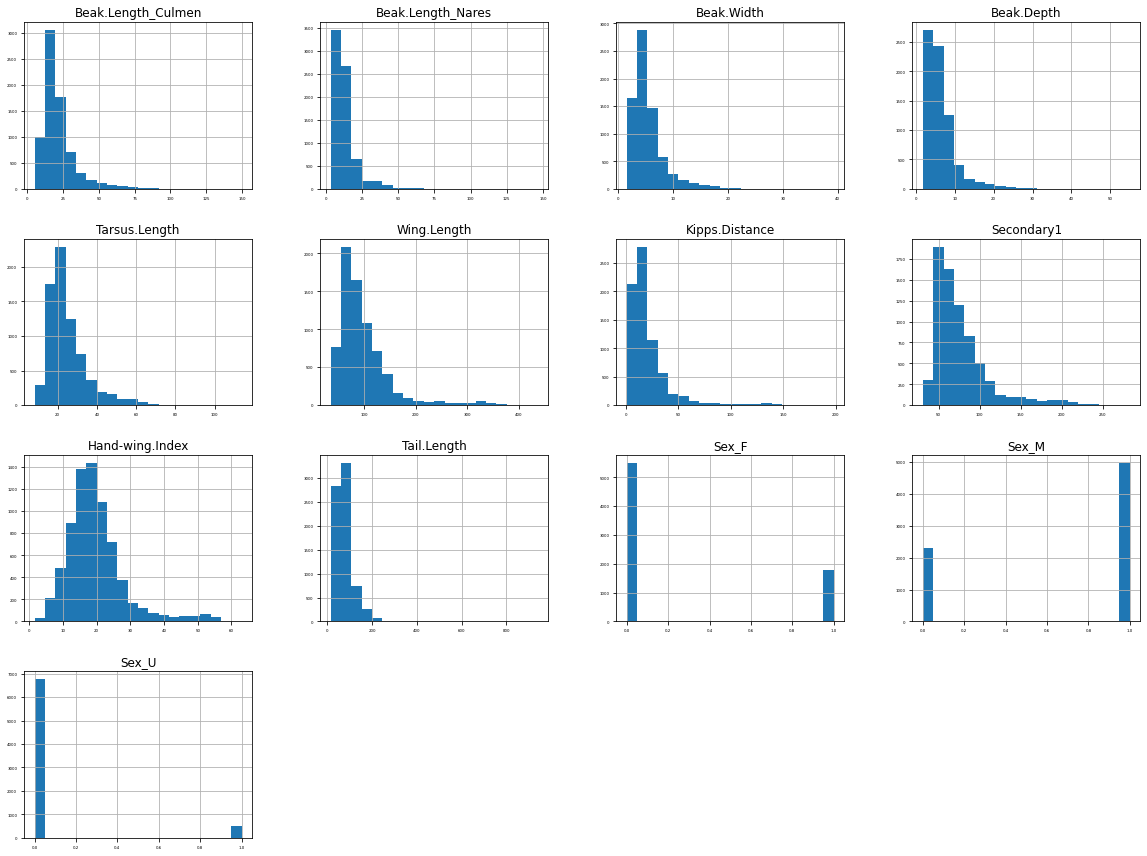

In [86]:
# histograms of the variables
fig = X_1.hist(figsize=[20,15], xlabelsize=4, ylabelsize=4, bins=20)
# show the plot
pyplot.show()

Mostrémosla con más detalle.

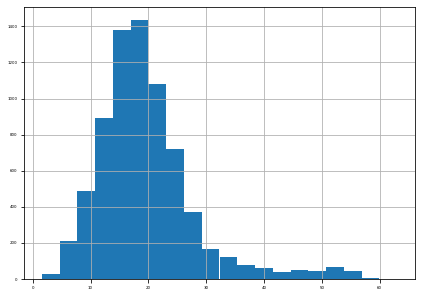

In [87]:
fig = X_1['Hand-wing.Index'].hist(figsize=[7,5], xlabelsize=4, ylabelsize=4, bins=20)
# show the plot
pyplot.show()

Eliminamos los outliers para esta variable y creamos un dataframe aparte. Podríamos emplear este dataframe (sin outliers en la variable `'Hand-wings.Index'`) par extraer resultados, pero como realmente dicha variable podría no seguir una distribución normal y además es tan solo una de todo el dataset, probaremos mejor con otras técnicas diferentes.

In [88]:
# calculate summary statistics
data_mean, data_std = np.mean(X_1['Hand-wing.Index']), np.std(X_1['Hand-wing.Index'])
# define outliers
cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off

In [89]:
X_1_SDM = X_1[(X_1['Hand-wing.Index'] >= lower) & (X_1['Hand-wing.Index'] <= upper)]

Observamos que hemos eliminado el grupo de outliers de la derecha (y quizá algunos valores extremos de la izquierda).

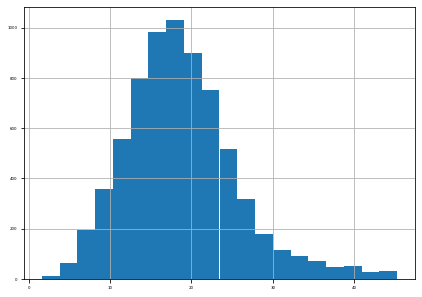

In [90]:
fig = X_1_SDM['Hand-wing.Index'].hist(figsize=[7,5], xlabelsize=4, ylabelsize=4, bins=20)
# show the plot
pyplot.show()

#### 2.4.2. Identificación de outliers mediante el Interquartile Range Method (IQR)

Mostremos el número de outliers identificados para cada variable por el método IQR.

In [91]:
for columna in X_1.columns:
    print(columna)
    # calculate interquartile range
    q25, q75 = np.percentile(X_1[columna], 25), np.percentile(X_1[columna], 75)
    iqr = q75 - q25
    print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))
    # calculate the outlier cutoff
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    # identify outliers
    outliers = [x for x in X_1[columna] if x < lower or x > upper]
    print('Identified outliers: %d' % len(outliers))
    print()

Beak.Length_Culmen
Percentiles: 25th=14.200, 75th=25.000, IQR=10.800
Identified outliers: 483

Beak.Length_Nares
Percentiles: 25th=8.200, 75th=14.618, IQR=6.418
Identified outliers: 513

Beak.Width
Percentiles: 25th=3.500, 75th=6.300, IQR=2.800
Identified outliers: 506

Beak.Depth
Percentiles: 25th=3.843, 75th=7.600, IQR=3.757
Identified outliers: 446

Tarsus.Length
Percentiles: 25th=18.300, 75th=28.600, IQR=10.300
Identified outliers: 445

Wing.Length
Percentiles: 25th=65.000, 75th=113.000, IQR=48.000
Identified outliers: 348

Kipps.Distance
Percentiles: 25th=10.000, 75th=24.505, IQR=14.505
Identified outliers: 536

Secondary1
Percentiles: 25th=53.584, 75th=87.000, IQR=33.416
Identified outliers: 472

Hand-wing.Index
Percentiles: 25th=14.352, 75th=22.900, IQR=8.548
Identified outliers: 369

Tail.Length
Percentiles: 25th=52.500, 75th=91.000, IQR=38.500
Identified outliers: 432

Sex_F
Percentiles: 25th=0.000, 75th=0.000, IQR=0.000
Identified outliers: 1784

Sex_M
Percentiles: 25th=0.000

Debemos tener en cuenta que las variables categóricas codificadas (`'Sex_F'`, `'Sex_M'` y `'Sex_U'`) son booleanas, por lo que en alguna de ellas (concretamente en la primera y la tercera) nos indica que todo el subconjunto de valores 1 son potenciales outliers. Debemos ignorar esto, como es natural.

#### 2.4.3. Borrado automático de outliers mediante el Local Outlier Factor (LOF)

Para poder utilizar LocalOutlierFactor en un Pipeline, creamos la siguiente clase, que nos permite combinar la técnica LOF con el modelo de predicción posterior.

In [92]:
class WithoutOutliersClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, outlier_detector, classifier):
        self.outlier_detector = outlier_detector
        self.classifier = classifier

    def fit(self, X, y):
        self.outlier_detector_ = clone(self.outlier_detector)
        mask = self.outlier_detector_.fit_predict(X, y) == 1
        self.classifier_ = clone(self.classifier).fit(X[mask], y[mask])
        return self

    def predict(self, X):
        return self.classifier_.predict(X)

Ahora, obtengamos los nuevos resultados tras eliminar los outliers.

* Dataset básico con una KNN Imputation con k=11, con un modelo de clasificación Multi-layer Perceptron (98,15%).

In [93]:
%%time

out = WithoutOutliersClassifier(LocalOutlierFactor(), models[0])
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(out, X_1, y_1, scoring='accuracy', cv=cv, n_jobs=-1)

print('>%.6f (%.3f)' % (np.mean(scores), np.std(scores)))

>0.979487 (0.004)
CPU times: total: 62.5 ms
Wall time: 5.1 s


* Dataset sin columnas con baja variedad de valores (`'Sex'`) con una Iterative Imputation con estimador Bayesian Ridge y estrategia ascending, con un modelo de clasificación Support Vector Machine (97,17%).

In [94]:
%%time

out = WithoutOutliersClassifier(LocalOutlierFactor(), models[1])
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(out, X_2, y_2, scoring='accuracy', cv=cv, n_jobs=-1)

print('>%.6f (%.3f)' % (np.mean(scores), np.std(scores)))

>0.971467 (0.002)
CPU times: total: 15.6 ms
Wall time: 791 ms


* Dataset sin columnas con baja variedad de valores (`'Sex'`) con una Iterative Imputation con estimador Lasso y estrategia arabic, con un modelo de clasificación Random Forest (98,42%).

In [95]:
%%time

out = WithoutOutliersClassifier(LocalOutlierFactor(), models[2])
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(out, X_3, y_3, scoring='accuracy', cv=cv, n_jobs=-1)

print('>%.6f (%.3f)' % (np.mean(scores), np.std(scores)))

>0.982275 (0.004)
CPU times: total: 62.5 ms
Wall time: 2.05 s


Los resultados son ligeramente peores (debemos tener en cuenta que hay subórdenes de aves muy distintas unas de otras, especialmente dentro del orden de los piciformes), pero la diferencia es tan baja que optaré por tener en cuenta esta técnica, ya que esto dará mayor solidez a las predicciones futuras.

In [96]:
out = LocalOutlierFactor()

mask1 = out.fit_predict(X_1, y_1) == 1
X_1_wo, y_1_wo = X_1[mask1], y_1[mask1]

mask2 = out.fit_predict(X_2, y_2) == 1
X_2_wo, y_2_wo = X_2[mask2], y_2[mask2]

mask3 = out.fit_predict(X_3, y_3) == 1
X_3_wo, y_3_wo = X_3[mask3], y_3[mask3]

print(X_1.shape)
print(X_2.shape)
print(X_3.shape)
print()
print(X_1_wo.shape)
print(X_2_wo.shape)
print(X_3_wo.shape)

(7280, 13)
(7278, 10)
(7278, 10)

(7089, 13)
(7094, 10)
(7091, 10)


### 2.6. Balanceo de Datos

Es posible ver que el dataset está claramente desbalanceado. Frente a los más de 7.000 registros que tenemos de passeriformes, solo contamos con 249 piciformes. Aunque en términos de Accuracy los resultados empeorarán seguramente tras hacer un escalado, nuestro objetivo será diferenciar correctamente entre un orden y otro, por lo que debemos, o trabajar con métricas equitativas como el F1-Score en su versión macro, o balancear previamente los datos.

In [97]:
counter = Counter(y_1)
print(counter)

oversample = ADASYN(n_neighbors=7)
# transform the dataset
X_1, y_1 = oversample.fit_resample(X_1, y_1)
# summarize the new class distribution
counter = Counter(y_1)
print(counter)

Counter({0: 7031, 1: 249})
Counter({0: 7031, 1: 7007})


In [98]:
counter = Counter(y_1_wo)
print(counter)

oversample = ADASYN(n_neighbors=7)
# transform the dataset
X_1_wo, y_1_wo = oversample.fit_resample(X_1_wo, y_1_wo)
# summarize the new class distribution
counter = Counter(y_1_wo)
print(counter)

Counter({0: 6875, 1: 214})
Counter({1: 6877, 0: 6875})


In [99]:
counter = Counter(y_2)
print(counter)

oversample = ADASYN(n_neighbors=7)
# transform the dataset
X_2, y_2 = oversample.fit_resample(X_2, y_2)
# summarize the new class distribution
counter = Counter(y_1)
print(counter)

Counter({0: 7029, 1: 249})
Counter({0: 7031, 1: 7007})


In [100]:
counter = Counter(y_2_wo)
print(counter)

oversample = ADASYN(n_neighbors=7)
# transform the dataset
X_2_wo, y_2_wo = oversample.fit_resample(X_2_wo, y_2_wo)
# summarize the new class distribution
counter = Counter(y_1_wo)
print(counter)

Counter({0: 6877, 1: 217})
Counter({1: 6877, 0: 6875})


In [101]:
counter = Counter(y_3)
print(counter)

oversample = ADASYN(n_neighbors=7)
# transform the dataset
X_3, y_3 = oversample.fit_resample(X_3, y_3)
# summarize the new class distribution
counter = Counter(y_3)
print(counter)

Counter({0: 7029, 1: 249})
Counter({1: 7045, 0: 7029})


In [102]:
counter = Counter(y_3_wo)
print(counter)

oversample = ADASYN(n_neighbors=7)
# transform the dataset
X_3_wo, y_3_wo = oversample.fit_resample(X_3_wo, y_3_wo)
# summarize the new class distribution
counter = Counter(y_3_wo)
print(counter)

Counter({0: 6875, 1: 216})
Counter({1: 6887, 0: 6875})


Dejo comentado el código para reducir la muestra de cada dataset, por si fuese necesario para poder ejecutar el código de las siguientes partes de código sin esperar horas.

In [103]:
# indices = np.random.choice(X_1.shape[0], 1000, replace=False)
# X_1 = X_1.iloc[indices]
# y_1 = y_1[indices]

# print(X_1.shape)
# print(y_1.shape)

In [104]:
# indices = np.random.choice(X_1_wo.shape[0], 1000, replace=False)
# X_1_wo = X_1_wo.iloc[indices]
# y_1_wo = y_1_wo[indices]

# print(X_1_wo.shape)
# print(y_1_wo.shape)

In [105]:
# indices = np.random.choice(X_2.shape[0], 1000, replace=False)
# X_2 = X_2.iloc[indices]
# y_2 = y_2[indices]

# print(X_2.shape)
# print(y_2.shape)

In [106]:
# indices = np.random.choice(X_2_wo.shape[0], 1000, replace=False)
# X_2_wo = X_2_wo.iloc[indices]
# y_2_wo = y_2_wo[indices]

# print(X_2_wo.shape)
# print(y_2_wo.shape)

In [107]:
# indices = np.random.choice(X_3.shape[0], 1000, replace=False)
# X_3 = X_3.iloc[indices]
# y_3 = y_3[indices]

# print(X_3.shape)
# print(y_3.shape)

In [108]:
# indices = np.random.choice(X_3_wo.shape[0], 1000, replace=False)
# X_3_wo = X_3_wo.iloc[indices]
# y_3_wo = y_3_wo[indices]

# print(X_3_wo.shape)
# print(y_3_wo.shape)

### 2.5. Escalado y transformaciones

En esta sección partiremos de los seis datasets obtenidos mediante las tres distintas estrategias de imputación de nulos (y sus contrapartes sin outliers). Nuestro objetivo será, por tanto, obtener una serie de resultados para distintos tratamientos y escalados de las variables numéricas del dataset de partida, pasando por distintos tipos de estandarización, normalización y otras transformaciones.

In [109]:
X_1.columns

Index(['Beak.Length_Culmen', 'Beak.Length_Nares', 'Beak.Width', 'Beak.Depth',
       'Tarsus.Length', 'Wing.Length', 'Kipps.Distance', 'Secondary1',
       'Hand-wing.Index', 'Tail.Length', 'Sex_F', 'Sex_M', 'Sex_U'],
      dtype='object')

Identificamos las columnas numéricas y categóricas.

In [110]:
numeric_columns = ['Beak.Length_Culmen', 'Beak.Length_Nares', 'Beak.Width', 'Beak.Depth',
       'Tarsus.Length', 'Wing.Length', 'Kipps.Distance', 'Secondary1',
       'Hand-wing.Index', 'Tail.Length']
cat_columns = ['Sex_F', 'Sex_M', 'Sex_U']

Para evaluar los modelos, utilizaremos un Cross Validation Repeated K-Fold con 10 splits y 3 repeticiones, e iremos guardando las métricas en un DataFrame de resultados.

In [111]:
scores = pd.DataFrame(columns=['Modelo', 
                               'Fitrado de Outliers',
                               'Estrategia de escalado',
                               'Accuracy (mean)',
                               'Accuracy (std)',
                               'Escalador'])

Para cada tipo de escalado seguiremos la misma estructura fija:

* Iteración para recorrer los tres modelos y cada parámtro del algoritmo de escalado.
* Definición del método de escalado aplicado a las variables numéricas o el Pipeline contenedor de dicho método.
* Ejecución del Cross Validation mediante un K-Fold de 5 splits.
* Muestra de los resultados y almacenamiento en el DataFrame de resultados.

In [112]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate 

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from numpy import mean
from numpy import std

#### 2.5.1. Normalización

Probamos a aplicar un `MinMaxScaler` a nuestros datos y obtenemos los resultados para los modelos.

In [113]:
%%time
    
scal = ColumnTransformer([('numeric',  MinMaxScaler(), numeric_columns)], remainder='passthrough')

pip = Pipeline(steps=[('scaler', scal),
                      ('model',  models[0])])

# preparar el procedimiento de cross-validation 
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluar el modelo
cv_results = cross_validate(pip, X_1, y_1, scoring='accuracy', cv=cv)

print('{:s}: {:.2f} ({:.2f})'.format(names[0], 
                                     mean(cv_results['test_score']), 
                                     std(cv_results['test_score'])))

scores.loc[len(scores)] = [names[0],
                           'No',
                           'Normalization',
                           mean(cv_results['test_score']),
                           std(cv_results['test_score']),
                           scal]

Multi-layer Perceptron Classifier: 0.96 (0.00)
CPU times: total: 36min 48s
Wall time: 4min 36s


In [114]:
%%time
    
scal = ColumnTransformer([('numeric',  MinMaxScaler(), numeric_columns)], remainder='passthrough')

pip = Pipeline(steps=[('scaler', scal),
                      ('model',  models[1])])

# preparar el procedimiento de cross-validation 
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluar el modelo
cv_results = cross_validate(pip, X_2, y_2, scoring='accuracy', cv=cv)

print('{:s}: {:.2f} ({:.2f})'.format(names[1], 
                                     mean(cv_results['test_score']), 
                                     std(cv_results['test_score'])))

scores.loc[len(scores)] = [names[1],
                           'No',
                           'Normalization',
                           mean(cv_results['test_score']),
                           std(cv_results['test_score']),
                           scal]

Support Vector Machine Classifier: 0.95 (0.00)
CPU times: total: 1min 2s
Wall time: 1min 1s
Parser   : 125 ms


In [115]:
%%time
    
scal = ColumnTransformer([('numeric',  MinMaxScaler(), numeric_columns)], remainder='passthrough')

pip = Pipeline(steps=[('scaler', scal),
                      ('model',  models[2])])

# preparar el procedimiento de cross-validation 
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluar el modelo
cv_results = cross_validate(pip, X_3, y_3, scoring='accuracy', cv=cv)

print('{:s}: {:.2f} ({:.2f})'.format(names[2], 
                                     mean(cv_results['test_score']), 
                                     std(cv_results['test_score'])))

scores.loc[len(scores)] = [names[2],
                           'No',
                           'Normalization',
                           mean(cv_results['test_score']),
                           std(cv_results['test_score']),
                           scal]

Random Forest Classifier: 0.99 (0.00)
CPU times: total: 53 s
Wall time: 53.1 s


In [116]:
%%time
    
scal = ColumnTransformer([('numeric',  MinMaxScaler(), numeric_columns)], remainder='passthrough')

pip = Pipeline(steps=[('scaler', scal),
                      ('model',  models[0])])

# preparar el procedimiento de cross-validation 
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluar el modelo
cv_results = cross_validate(pip, X_1_wo, y_1_wo, scoring='accuracy', cv=cv)

print('{:s}: {:.2f} ({:.2f})'.format(names[0], 
                                     mean(cv_results['test_score']), 
                                     std(cv_results['test_score'])))

scores.loc[len(scores)] = [names[0],
                           'Yes',
                           'Normalization',
                           mean(cv_results['test_score']),
                           std(cv_results['test_score']),
                           scal]

Multi-layer Perceptron Classifier: 0.97 (0.00)
CPU times: total: 36min 47s
Wall time: 4min 36s


In [117]:
%%time
    
scal = ColumnTransformer([('numeric',  MinMaxScaler(), numeric_columns)], remainder='passthrough')

pip = Pipeline(steps=[('scaler', scal),
                      ('model',  models[1])])

# preparar el procedimiento de cross-validation 
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluar el modelo
cv_results = cross_validate(pip, X_2_wo, y_2_wo, scoring='accuracy', cv=cv)

print('{:s}: {:.2f} ({:.2f})'.format(names[1], 
                                     mean(cv_results['test_score']), 
                                     std(cv_results['test_score'])))

scores.loc[len(scores)] = [names[1],
                           'Yes',
                           'Normalization',
                           mean(cv_results['test_score']),
                           std(cv_results['test_score']),
                           scal]

Support Vector Machine Classifier: 0.95 (0.01)
CPU times: total: 58.5 s
Wall time: 57.2 s


In [118]:
%%time
    
scal = ColumnTransformer([('numeric',  MinMaxScaler(), numeric_columns)], remainder='passthrough')

pip = Pipeline(steps=[('scaler', scal),
                      ('model',  models[2])])

# preparar el procedimiento de cross-validation 
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluar el modelo
cv_results = cross_validate(pip, X_3_wo, y_3_wo, scoring='accuracy', cv=cv)

print('{:s}: {:.2f} ({:.2f})'.format(names[2], 
                                     mean(cv_results['test_score']), 
                                     std(cv_results['test_score'])))

scores.loc[len(scores)] = [names[2],
                           'Yes',
                           'Normalization',
                           mean(cv_results['test_score']),
                           std(cv_results['test_score']),
                           scal]

Random Forest Classifier: 0.99 (0.00)
CPU times: total: 52.2 s
Wall time: 52.3 s


Finalmente, mostramos los resultados para el método de escalado concreto; en nuestro caso, el de normalización.

In [119]:
scores[scores['Estrategia de escalado'] == 'Normalization'].sort_values('Accuracy (mean)', ascending=False)

,Modelo,Fitrado de Outliers,Estrategia de escalado,Accuracy (mean),Accuracy (std),Escalador
5,Random Forest Classifier,Yes,Normalization,0.994042,0.001803,"ColumnTransformer(remainder='passthrough',\n ..."
2,Random Forest Classifier,No,Normalization,0.993155,0.002251,"ColumnTransformer(remainder='passthrough',\n ..."
3,Multi-layer Perceptron Classifier,Yes,Normalization,0.970453,0.003128,"ColumnTransformer(remainder='passthrough',\n ..."
0,Multi-layer Perceptron Classifier,No,Normalization,0.963005,0.004865,"ColumnTransformer(remainder='passthrough',\n ..."
4,Support Vector Machine Classifier,Yes,Normalization,0.954303,0.005739,"ColumnTransformer(remainder='passthrough',\n ..."
1,Support Vector Machine Classifier,No,Normalization,0.949811,0.004673,"ColumnTransformer(remainder='passthrough',\n ..."


#### 2.5.2. Estandarización

Pasamos a utilizar un `StandardScaler` en nuestros datos. Los resultados obtenidos son similares.

In [120]:
%%time
    
scal = ColumnTransformer([('numeric',  StandardScaler(), numeric_columns)], remainder='passthrough')

pip = Pipeline(steps=[('scaler', scal),
                      ('model',  models[0])])

# preparar el procedimiento de cross-validation 
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluar el modelo
cv_results = cross_validate(pip, X_1, y_1, scoring='accuracy', cv=cv)

print('{:s}: {:.2f} ({:.2f})'.format(names[0], 
                                     mean(cv_results['test_score']), 
                                     std(cv_results['test_score'])))

scores.loc[len(scores)] = [names[0],
                           'No',
                           'Standarization',
                           mean(cv_results['test_score']),
                           std(cv_results['test_score']),
                           scal]

Multi-layer Perceptron Classifier: 0.99 (0.00)
CPU times: total: 41min 49s
Wall time: 5min 14s


In [121]:
%%time
    
scal = ColumnTransformer([('numeric',  StandardScaler(), numeric_columns)], remainder='passthrough')

pip = Pipeline(steps=[('scaler', scal),
                      ('model',  models[1])])

# preparar el procedimiento de cross-validation 
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluar el modelo
cv_results = cross_validate(pip, X_2, y_2, scoring='accuracy', cv=cv)

print('{:s}: {:.2f} ({:.2f})'.format(names[1], 
                                     mean(cv_results['test_score']), 
                                     std(cv_results['test_score'])))

scores.loc[len(scores)] = [names[1],
                           'No',
                           'Standarization',
                           mean(cv_results['test_score']),
                           std(cv_results['test_score']),
                           scal]

Support Vector Machine Classifier: 0.97 (0.00)
CPU times: total: 46.7 s
Wall time: 45.5 s


In [122]:
%%time
    
scal = ColumnTransformer([('numeric',  StandardScaler(), numeric_columns)], remainder='passthrough')

pip = Pipeline(steps=[('scaler', scal),
                      ('model',  models[2])])

# preparar el procedimiento de cross-validation 
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluar el modelo
cv_results = cross_validate(pip, X_3, y_3, scoring='accuracy', cv=cv)

print('{:s}: {:.2f} ({:.2f})'.format(names[2], 
                                     mean(cv_results['test_score']), 
                                     std(cv_results['test_score'])))

scores.loc[len(scores)] = [names[2],
                           'No',
                           'Standarization',
                           mean(cv_results['test_score']),
                           std(cv_results['test_score']),
                           scal]

Random Forest Classifier: 0.99 (0.00)
CPU times: total: 53 s
Wall time: 53 s


In [123]:
%%time
    
scal = ColumnTransformer([('numeric',  StandardScaler(), numeric_columns)], remainder='passthrough')

pip = Pipeline(steps=[('scaler', scal),
                      ('model',  models[0])])

# preparar el procedimiento de cross-validation 
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluar el modelo
cv_results = cross_validate(pip, X_1_wo, y_1_wo, scoring='accuracy', cv=cv)

print('{:s}: {:.2f} ({:.2f})'.format(names[0], 
                                     mean(cv_results['test_score']), 
                                     std(cv_results['test_score'])))

scores.loc[len(scores)] = [names[0],
                           'Yes',
                           'Standarization',
                           mean(cv_results['test_score']),
                           std(cv_results['test_score']),
                           scal]

Multi-layer Perceptron Classifier: 0.99 (0.00)
CPU times: total: 39min 47s
Wall time: 4min 58s


In [124]:
%%time
    
scal = ColumnTransformer([('numeric',  StandardScaler(), numeric_columns)], remainder='passthrough')

pip = Pipeline(steps=[('scaler', scal),
                      ('model',  models[1])])

# preparar el procedimiento de cross-validation 
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluar el modelo
cv_results = cross_validate(pip, X_2_wo, y_2_wo, scoring='accuracy', cv=cv)

print('{:s}: {:.2f} ({:.2f})'.format(names[1], 
                                     mean(cv_results['test_score']), 
                                     std(cv_results['test_score'])))

scores.loc[len(scores)] = [names[1],
                           'Yes',
                           'Standarization',
                           mean(cv_results['test_score']),
                           std(cv_results['test_score']),
                           scal]

Support Vector Machine Classifier: 0.97 (0.00)
CPU times: total: 42.1 s
Wall time: 40.8 s


In [125]:
%%time
    
scal = ColumnTransformer([('numeric',  StandardScaler(), numeric_columns)], remainder='passthrough')

pip = Pipeline(steps=[('scaler', scal),
                      ('model',  models[2])])

# preparar el procedimiento de cross-validation 
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluar el modelo
cv_results = cross_validate(pip, X_3_wo, y_3_wo, scoring='accuracy', cv=cv)

print('{:s}: {:.2f} ({:.2f})'.format(names[2], 
                                     mean(cv_results['test_score']), 
                                     std(cv_results['test_score'])))

scores.loc[len(scores)] = [names[2],
                           'Yes',
                           'Standarization',
                           mean(cv_results['test_score']),
                           std(cv_results['test_score']),
                           scal]

Random Forest Classifier: 0.99 (0.00)
CPU times: total: 53.6 s
Wall time: 53.7 s


In [126]:
scores[scores['Estrategia de escalado'] == 'Standarization'].sort_values('Accuracy (mean)', ascending=False)

,Modelo,Fitrado de Outliers,Estrategia de escalado,Accuracy (mean),Accuracy (std),Escalador
11,Random Forest Classifier,Yes,Standarization,0.994090,0.001816,"ColumnTransformer(remainder='passthrough',\n ..."
9,Multi-layer Perceptron Classifier,Yes,Standarization,0.993868,0.002028,"ColumnTransformer(remainder='passthrough',\n ..."
8,Random Forest Classifier,No,Standarization,0.993203,0.002073,"ColumnTransformer(remainder='passthrough',\n ..."
6,Multi-layer Perceptron Classifier,No,Standarization,0.992639,0.002698,"ColumnTransformer(remainder='passthrough',\n ..."
10,Support Vector Machine Classifier,Yes,Standarization,0.971152,0.004200,"ColumnTransformer(remainder='passthrough',\n ..."
7,Support Vector Machine Classifier,No,Standarization,0.969460,0.003860,"ColumnTransformer(remainder='passthrough',\n ..."


#### 2.5.3. Estandarización mediante Robust Scaling (RS)

Para la estandarización mediante un `RobustScaler`, debemos elegir el valor de `quantile_range` para determinar el rango de cuartiles que ha de tener en cuenta. Tomamos este valor de una lista concreta y añadimos los resultados al grid.

In [127]:
%%time

for value in [1, 5, 10, 15, 20, 25, 30]:
    scal = ColumnTransformer([('numeric', RobustScaler(quantile_range=(value, 100-value)), numeric_columns)], remainder='passthrough')

    pip = Pipeline(steps=[('scaler', scal),
                          ('model',  models[0])])

    # preparar el procedimiento de cross-validation 
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # evaluar el modelo
    cv_results = cross_validate(pip, X_1, y_1, scoring='accuracy', cv=cv)

    print('Quantile Range: ', value)
    print('{:s}: {:.2f} ({:.2f})'.format(names[0], 
                                         mean(cv_results['test_score']), 
                                         std(cv_results['test_score'])))

    scores.loc[len(scores)] = [names[0],
                               'No',
                               'RobustScaling - ' + str(value),
                               mean(cv_results['test_score']),
                               std(cv_results['test_score']),
                               scal]

Quantile Range:  1
Multi-layer Perceptron Classifier: 0.99 (0.00)
Quantile Range:  5
Multi-layer Perceptron Classifier: 0.99 (0.00)
Quantile Range:  10
Multi-layer Perceptron Classifier: 0.99 (0.00)
Quantile Range:  15
Multi-layer Perceptron Classifier: 0.99 (0.00)
Quantile Range:  20
Multi-layer Perceptron Classifier: 0.99 (0.00)
Quantile Range:  25
Multi-layer Perceptron Classifier: 0.99 (0.00)
Quantile Range:  30
Multi-layer Perceptron Classifier: 0.99 (0.00)
CPU times: total: 4h 43min 38s
Wall time: 35min 29s


In [128]:
%%time

for value in [1, 5, 10, 15, 20, 25, 30]:
    scal = ColumnTransformer([('numeric', RobustScaler(quantile_range=(value, 100-value)), numeric_columns)], remainder='passthrough')

    pip = Pipeline(steps=[('scaler', scal),
                          ('model',  models[1])])

    # preparar el procedimiento de cross-validation 
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # evaluar el modelo
    cv_results = cross_validate(pip, X_2, y_2, scoring='accuracy', cv=cv)

    print('Quantile Range: ', value)
    print('{:s}: {:.2f} ({:.2f})'.format(names[1], 
                                         mean(cv_results['test_score']), 
                                         std(cv_results['test_score'])))

    scores.loc[len(scores)] = [names[1],
                               'No',
                               'RobustScaling - ' + str(value),
                               mean(cv_results['test_score']),
                               std(cv_results['test_score']),
                               scal]

Quantile Range:  1
Support Vector Machine Classifier: 0.97 (0.00)
Quantile Range:  5
Support Vector Machine Classifier: 0.97 (0.00)
Quantile Range:  10
Support Vector Machine Classifier: 0.97 (0.00)
Quantile Range:  15
Support Vector Machine Classifier: 0.97 (0.00)
Quantile Range:  20
Support Vector Machine Classifier: 0.97 (0.00)
Quantile Range:  25
Support Vector Machine Classifier: 0.97 (0.00)
Quantile Range:  30
Support Vector Machine Classifier: 0.97 (0.00)
CPU times: total: 5min 27s
Wall time: 5min 26s


In [129]:
%%time

for value in [1, 5, 10, 15, 20, 25, 30]:
    scal = ColumnTransformer([('numeric', RobustScaler(quantile_range=(value, 100-value)), numeric_columns)], remainder='passthrough')

    pip = Pipeline(steps=[('scaler', scal),
                          ('model',  models[2])])

    # preparar el procedimiento de cross-validation 
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # evaluar el modelo
    cv_results = cross_validate(pip, X_3, y_3, scoring='accuracy', cv=cv)

    print('Quantile Range: ', value)
    print('{:s}: {:.2f} ({:.2f})'.format(names[2], 
                                         mean(cv_results['test_score']), 
                                         std(cv_results['test_score'])))

    scores.loc[len(scores)] = [names[2],
                               'No',
                               'RobustScaling - ' + str(value),
                               mean(cv_results['test_score']),
                               std(cv_results['test_score']),
                               scal]

Quantile Range:  1
Random Forest Classifier: 0.99 (0.00)
Quantile Range:  5
Random Forest Classifier: 0.99 (0.00)
Quantile Range:  10
Random Forest Classifier: 0.99 (0.00)
Quantile Range:  15
Random Forest Classifier: 0.99 (0.00)
Quantile Range:  20
Random Forest Classifier: 0.99 (0.00)
Quantile Range:  25
Random Forest Classifier: 0.99 (0.00)
Quantile Range:  30
Random Forest Classifier: 0.99 (0.00)
CPU times: total: 6min 12s
Wall time: 6min 12s


In [130]:
%%time

for value in [1, 5, 10, 15, 20, 25, 30]:
    scal = ColumnTransformer([('numeric', RobustScaler(quantile_range=(value, 100-value)), numeric_columns)], remainder='passthrough')

    pip = Pipeline(steps=[('scaler', scal),
                          ('model',  models[0])])

    # preparar el procedimiento de cross-validation 
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # evaluar el modelo
    cv_results = cross_validate(pip, X_1_wo, y_1_wo, scoring='accuracy', cv=cv)

    print('Quantile Range: ', value)
    print('{:s}: {:.2f} ({:.2f})'.format(names[0], 
                                         mean(cv_results['test_score']), 
                                         std(cv_results['test_score'])))

    scores.loc[len(scores)] = [names[0],
                               'Yes',
                               'RobustScaling - ' + str(value),
                               mean(cv_results['test_score']),
                               std(cv_results['test_score']),
                               scal]

Quantile Range:  1
Multi-layer Perceptron Classifier: 0.99 (0.00)
Quantile Range:  5
Multi-layer Perceptron Classifier: 0.99 (0.00)
Quantile Range:  10
Multi-layer Perceptron Classifier: 0.99 (0.00)
Quantile Range:  15
Multi-layer Perceptron Classifier: 0.99 (0.00)
Quantile Range:  20
Multi-layer Perceptron Classifier: 0.99 (0.00)
Quantile Range:  25
Multi-layer Perceptron Classifier: 0.99 (0.00)
Quantile Range:  30
Multi-layer Perceptron Classifier: 0.99 (0.00)
CPU times: total: 4h 43min 50s
Wall time: 35min 34s


In [131]:
%%time

for value in [1, 5, 10, 15, 20, 25, 30]:
    scal = ColumnTransformer([('numeric', RobustScaler(quantile_range=(value, 100-value)), numeric_columns)], remainder='passthrough')

    pip = Pipeline(steps=[('scaler', scal),
                          ('model',  models[1])])

    # preparar el procedimiento de cross-validation 
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # evaluar el modelo
    cv_results = cross_validate(pip, X_2_wo, y_2_wo, scoring='accuracy', cv=cv)

    print('Quantile Range: ', value)
    print('{:s}: {:.2f} ({:.2f})'.format(names[1], 
                                         mean(cv_results['test_score']), 
                                         std(cv_results['test_score'])))

    scores.loc[len(scores)] = [names[1],
                               'Yes',
                               'RobustScaling - ' + str(value),
                               mean(cv_results['test_score']),
                               std(cv_results['test_score']),
                               scal]

Quantile Range:  1
Support Vector Machine Classifier: 0.97 (0.00)
Quantile Range:  5
Support Vector Machine Classifier: 0.97 (0.00)
Quantile Range:  10
Support Vector Machine Classifier: 0.97 (0.00)
Quantile Range:  15
Support Vector Machine Classifier: 0.97 (0.00)
Quantile Range:  20
Support Vector Machine Classifier: 0.97 (0.00)
Quantile Range:  25
Support Vector Machine Classifier: 0.97 (0.00)
Quantile Range:  30
Support Vector Machine Classifier: 0.97 (0.00)
CPU times: total: 4min 54s
Wall time: 4min 53s


In [132]:
%%time

for value in [1, 5, 10, 15, 20, 25, 30]:
    scal = ColumnTransformer([('numeric', RobustScaler(quantile_range=(value, 100-value)), numeric_columns)], remainder='passthrough')

    pip = Pipeline(steps=[('scaler', scal),
                          ('model',  models[2])])

    # preparar el procedimiento de cross-validation 
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # evaluar el modelo
    cv_results = cross_validate(pip, X_3_wo, y_3_wo, scoring='accuracy', cv=cv)

    print('Quantile Range: ', value)
    print('{:s}: {:.2f} ({:.2f})'.format(names[2], 
                                         mean(cv_results['test_score']), 
                                         std(cv_results['test_score'])))

    scores.loc[len(scores)] = [names[2],
                               'Yes',
                               'RobustScaling - ' + str(value),
                               mean(cv_results['test_score']),
                               std(cv_results['test_score']),
                               scal]

Quantile Range:  1
Random Forest Classifier: 0.99 (0.00)
Quantile Range:  5
Random Forest Classifier: 0.99 (0.00)
Quantile Range:  10
Random Forest Classifier: 0.99 (0.00)
Quantile Range:  15
Random Forest Classifier: 0.99 (0.00)
Quantile Range:  20
Random Forest Classifier: 0.99 (0.00)
Quantile Range:  25
Random Forest Classifier: 0.99 (0.00)
Quantile Range:  30
Random Forest Classifier: 0.99 (0.00)
CPU times: total: 6min 9s
Wall time: 6min 10s


In [133]:
scores[scores['Estrategia de escalado'].str[0:13] == 'RobustScaling'].sort_values('Accuracy (mean)', ascending=False)

,Modelo,Fitrado de Outliers,Estrategia de escalado,Accuracy (mean),Accuracy (std),Escalador
39,Multi-layer Perceptron Classifier,Yes,RobustScaling - 30,0.994498,0.001884,"ColumnTransformer(remainder='passthrough',\n ..."
18,Multi-layer Perceptron Classifier,No,RobustScaling - 30,0.994396,0.001978,"ColumnTransformer(remainder='passthrough',\n ..."
49,Random Forest Classifier,Yes,RobustScaling - 10,0.994090,0.001816,"ColumnTransformer(remainder='passthrough',\n ..."
50,Random Forest Classifier,Yes,RobustScaling - 15,0.994090,0.001816,"ColumnTransformer(remainder='passthrough',\n ..."
51,Random Forest Classifier,Yes,RobustScaling - 20,0.994090,0.001816,"ColumnTransformer(remainder='passthrough',\n ..."
52,Random Forest Classifier,Yes,RobustScaling - 25,0.994090,0.001816,"ColumnTransformer(remainder='passthrough',\n ..."
53,Random Forest Classifier,Yes,RobustScaling - 30,0.994090,0.001816,"ColumnTransformer(remainder='passthrough',\n ..."
48,Random Forest Classifier,Yes,RobustScaling - 5,0.994066,0.001829,"ColumnTransformer(remainder='passthrough',\n ..."
47,Random Forest Classifier,Yes,RobustScaling - 1,0.994042,0.001851,"ColumnTransformer(remainder='passthrough',\n ..."
38,Multi-layer Perceptron Classifier,Yes,RobustScaling - 25,0.994037,0.001694,"ColumnTransformer(remainder='passthrough',\n ..."


#### 2.5.4. Transformación de los datos mediante Power Transform (PT)

Para el método de transformación de la distribución de los datos Power Transform, utilizamos los métodos de Yeo-Johnson y Box-Cox. Para que este segundo funcione correctamente, debemos asegurarnos de que los datos son positivos, por lo que tendremos que aplicar una estandarización previa de los valores de las variables.

Para evitar posibles problemas futuros, escalamos entre 1 y 2, con el fin de que no exista ningún futuro valor atípico en el conjunto de predicción que se haga negativo.

In [134]:
%%time

for method in ['yeo-johnson', 'box-cox']:
    for standardize in [False, True]:
        nor_pt = Pipeline(steps=[('normalize', MinMaxScaler(feature_range=(1, 2))),
                              ('powertransformation',  PowerTransformer(method=method, standardize=standardize))])

        scal = ColumnTransformer([('numeric',  nor_pt, numeric_columns)], remainder='passthrough')

        pip = Pipeline(steps=[('scaler', scal),
                              ('model',  models[0])])

        # preparar el procedimiento de cross-validation 
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        # evaluar el modelo
        cv_results = cross_validate(pip, X_1, y_1, scoring='accuracy', cv=cv)

        print('PowerTransformation - ' + str(method) + ' - PreNormalized - St.: ' + str(standardize))
        print('{:s}: {:.2f} ({:.2f})'.format(names[0], 
                                             mean(cv_results['test_score']), 
                                             std(cv_results['test_score'])))

        scores.loc[len(scores)] = [names[0],
                                   'No',
                                   'PowerTransformation - ' + str(method) + ' - PreNormalized - St.: ' + str(standardize),
                                   mean(cv_results['test_score']),
                                   std(cv_results['test_score']),
                                   scal]

PowerTransformation - yeo-johnson - PreNormalized - St.: False
Multi-layer Perceptron Classifier: 0.66 (0.01)
PowerTransformation - yeo-johnson - PreNormalized - St.: True
Multi-layer Perceptron Classifier: 0.99 (0.00)
PowerTransformation - box-cox - PreNormalized - St.: False
Multi-layer Perceptron Classifier: 0.94 (0.01)
PowerTransformation - box-cox - PreNormalized - St.: True
Multi-layer Perceptron Classifier: 0.99 (0.00)
CPU times: total: 2h 21min 23s
Wall time: 17min 41s


In [135]:
%%time

for method in ['yeo-johnson', 'box-cox']:
    for standardize in [False, True]:
        nor_pt = Pipeline(steps=[('normalize', MinMaxScaler(feature_range=(1, 2))),
                              ('powertransformation',  PowerTransformer(method=method, standardize=standardize))])

        scal = ColumnTransformer([('numeric',  nor_pt, numeric_columns)], remainder='passthrough')

        pip = Pipeline(steps=[('scaler', scal),
                              ('model',  models[1])])

        # preparar el procedimiento de cross-validation 
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        # evaluar el modelo
        cv_results = cross_validate(pip, X_2, y_2, scoring='accuracy', cv=cv)

        print('PowerTransformation - ' + str(method) + ' - PreNormalized - St.: ' + str(standardize))
        print('{:s}: {:.2f} ({:.2f})'.format(names[1], 
                                             mean(cv_results['test_score']), 
                                             std(cv_results['test_score'])))

        scores.loc[len(scores)] = [names[1],
                                   'No',
                                   'PowerTransformation - ' + str(method) + ' - PreNormalized - St.: ' + str(standardize),
                                   mean(cv_results['test_score']),
                                   std(cv_results['test_score']),
                                   scal]

PowerTransformation - yeo-johnson - PreNormalized - St.: False
Support Vector Machine Classifier: 0.50 (0.00)
PowerTransformation - yeo-johnson - PreNormalized - St.: True
Support Vector Machine Classifier: 0.97 (0.00)
PowerTransformation - box-cox - PreNormalized - St.: False
Support Vector Machine Classifier: 0.93 (0.01)
PowerTransformation - box-cox - PreNormalized - St.: True
Support Vector Machine Classifier: 0.97 (0.00)
CPU times: total: 6min 37s
Wall time: 6min 36s


In [136]:
%%time

for method in ['yeo-johnson', 'box-cox']:
    for standardize in [False, True]:
        nor_pt = Pipeline(steps=[('normalize', MinMaxScaler(feature_range=(1, 2))),
                              ('powertransformation',  PowerTransformer(method=method, standardize=standardize))])

        scal = ColumnTransformer([('numeric',  nor_pt, numeric_columns)], remainder='passthrough')

        pip = Pipeline(steps=[('scaler', scal),
                              ('model',  models[2])])

        # preparar el procedimiento de cross-validation 
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        # evaluar el modelo
        cv_results = cross_validate(pip, X_3, y_3, scoring='accuracy', cv=cv)

        print('PowerTransformation - ' + str(method) + ' - PreNormalized - St.: ' + str(standardize))
        print('{:s}: {:.2f} ({:.2f})'.format(names[2], 
                                             mean(cv_results['test_score']), 
                                             std(cv_results['test_score'])))

        scores.loc[len(scores)] = [names[2],
                                   'No',
                                   'PowerTransformation - ' + str(method) + ' - PreNormalized - St.: ' + str(standardize),
                                   mean(cv_results['test_score']),
                                   std(cv_results['test_score']),
                                   scal]

PowerTransformation - yeo-johnson - PreNormalized - St.: False
Random Forest Classifier: 0.91 (0.04)
PowerTransformation - yeo-johnson - PreNormalized - St.: True
Random Forest Classifier: 0.99 (0.00)
PowerTransformation - box-cox - PreNormalized - St.: False
Random Forest Classifier: 0.99 (0.00)
PowerTransformation - box-cox - PreNormalized - St.: True
Random Forest Classifier: 0.99 (0.00)
CPU times: total: 3min 19s
Wall time: 3min 19s


In [137]:
%%time

for method in ['yeo-johnson', 'box-cox']:
    for standardize in [False, True]:
        nor_pt = Pipeline(steps=[('normalize', MinMaxScaler(feature_range=(1, 2))),
                              ('powertransformation',  PowerTransformer(method=method, standardize=standardize))])

        scal = ColumnTransformer([('numeric',  nor_pt, numeric_columns)], remainder='passthrough')

        pip = Pipeline(steps=[('scaler', scal),
                              ('model',  models[0])])

        # preparar el procedimiento de cross-validation 
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        # evaluar el modelo
        cv_results = cross_validate(pip, X_1_wo, y_1_wo, scoring='accuracy', cv=cv)

        print('PowerTransformation - ' + str(method) + ' - PreNormalized - St.: ' + str(standardize))
        print('{:s}: {:.2f} ({:.2f})'.format(names[0], 
                                             mean(cv_results['test_score']), 
                                             std(cv_results['test_score'])))

        scores.loc[len(scores)] = [names[0],
                                   'Yes',
                                   'PowerTransformation - ' + str(method) + ' - PreNormalized - St.: ' + str(standardize),
                                   mean(cv_results['test_score']),
                                   std(cv_results['test_score']),
                                   scal]

PowerTransformation - yeo-johnson - PreNormalized - St.: False
Multi-layer Perceptron Classifier: 0.64 (0.01)
PowerTransformation - yeo-johnson - PreNormalized - St.: True
Multi-layer Perceptron Classifier: 0.99 (0.00)
PowerTransformation - box-cox - PreNormalized - St.: False
Multi-layer Perceptron Classifier: 0.95 (0.00)
PowerTransformation - box-cox - PreNormalized - St.: True
Multi-layer Perceptron Classifier: 0.99 (0.00)
CPU times: total: 2h 19min 9s
Wall time: 17min 24s


In [138]:
%%time

for method in ['yeo-johnson', 'box-cox']:
    for standardize in [False, True]:
        nor_pt = Pipeline(steps=[('normalize', MinMaxScaler(feature_range=(1, 2))),
                              ('powertransformation',  PowerTransformer(method=method, standardize=standardize))])

        scal = ColumnTransformer([('numeric',  nor_pt, numeric_columns)], remainder='passthrough')

        pip = Pipeline(steps=[('scaler', scal),
                              ('model',  models[1])])

        # preparar el procedimiento de cross-validation 
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        # evaluar el modelo
        cv_results = cross_validate(pip, X_2_wo, y_2_wo, scoring='accuracy', cv=cv)

        print('PowerTransformation - ' + str(method) + ' - PreNormalized - St.: ' + str(standardize))
        print('{:s}: {:.2f} ({:.2f})'.format(names[1], 
                                             mean(cv_results['test_score']), 
                                             std(cv_results['test_score'])))

        scores.loc[len(scores)] = [names[1],
                                   'Yes',
                                   'PowerTransformation - ' + str(method) + ' - PreNormalized - St.: ' + str(standardize),
                                   mean(cv_results['test_score']),
                                   std(cv_results['test_score']),
                                   scal]

PowerTransformation - yeo-johnson - PreNormalized - St.: False
Support Vector Machine Classifier: 0.50 (0.01)
PowerTransformation - yeo-johnson - PreNormalized - St.: True
Support Vector Machine Classifier: 0.98 (0.00)
PowerTransformation - box-cox - PreNormalized - St.: False
Support Vector Machine Classifier: 0.94 (0.01)
PowerTransformation - box-cox - PreNormalized - St.: True
Support Vector Machine Classifier: 0.98 (0.00)
CPU times: total: 6min 11s
Wall time: 6min 9s


In [139]:
%%time

for method in ['yeo-johnson', 'box-cox']:
    for standardize in [False, True]:
        nor_pt = Pipeline(steps=[('normalize', MinMaxScaler(feature_range=(1, 2))),
                              ('powertransformation',  PowerTransformer(method=method, standardize=standardize))])

        scal = ColumnTransformer([('numeric',  nor_pt, numeric_columns)], remainder='passthrough')

        pip = Pipeline(steps=[('scaler', scal),
                              ('model',  models[2])])

        # preparar el procedimiento de cross-validation 
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        # evaluar el modelo
        cv_results = cross_validate(pip, X_3_wo, y_3_wo, scoring='accuracy', cv=cv)

        print('PowerTransformation - ' + str(method) + ' - PreNormalized - St.: ' + str(standardize))
        print('{:s}: {:.2f} ({:.2f})'.format(names[2], 
                                             mean(cv_results['test_score']), 
                                             std(cv_results['test_score'])))

        scores.loc[len(scores)] = [names[2],
                                   'Yes',
                                   'PowerTransformation - ' + str(method) + ' - PreNormalized - St.: ' + str(standardize),
                                   mean(cv_results['test_score']),
                                   std(cv_results['test_score']),
                                   scal]

PowerTransformation - yeo-johnson - PreNormalized - St.: False
Random Forest Classifier: 0.99 (0.00)
PowerTransformation - yeo-johnson - PreNormalized - St.: True
Random Forest Classifier: 0.99 (0.00)
PowerTransformation - box-cox - PreNormalized - St.: False
Random Forest Classifier: 0.99 (0.00)
PowerTransformation - box-cox - PreNormalized - St.: True
Random Forest Classifier: 0.99 (0.00)
CPU times: total: 3min 45s
Wall time: 3min 45s


In [140]:
scores[scores['Estrategia de escalado'].str[0:19] == 'PowerTransformation'].sort_values('Accuracy (mean)', ascending=False)

,Modelo,Fitrado de Outliers,Estrategia de escalado,Accuracy (mean),Accuracy (std),Escalador
67,Multi-layer Perceptron Classifier,Yes,PowerTransformation - yeo-johnson - PreNormali...,0.994134,0.002132,"ColumnTransformer(remainder='passthrough',\n ..."
77,Random Forest Classifier,Yes,PowerTransformation - box-cox - PreNormalized ...,0.994090,0.001816,"ColumnTransformer(remainder='passthrough',\n ..."
75,Random Forest Classifier,Yes,PowerTransformation - yeo-johnson - PreNormali...,0.994090,0.001816,"ColumnTransformer(remainder='passthrough',\n ..."
76,Random Forest Classifier,Yes,PowerTransformation - box-cox - PreNormalized ...,0.994066,0.001771,"ColumnTransformer(remainder='passthrough',\n ..."
69,Multi-layer Perceptron Classifier,Yes,PowerTransformation - box-cox - PreNormalized ...,0.993916,0.001726,"ColumnTransformer(remainder='passthrough',\n ..."
63,Random Forest Classifier,No,PowerTransformation - yeo-johnson - PreNormali...,0.993179,0.002073,"ColumnTransformer(remainder='passthrough',\n ..."
65,Random Forest Classifier,No,PowerTransformation - box-cox - PreNormalized ...,0.993179,0.002073,"ColumnTransformer(remainder='passthrough',\n ..."
64,Random Forest Classifier,No,PowerTransformation - box-cox - PreNormalized ...,0.993060,0.002390,"ColumnTransformer(remainder='passthrough',\n ..."
57,Multi-layer Perceptron Classifier,No,PowerTransformation - box-cox - PreNormalized ...,0.992805,0.002490,"ColumnTransformer(remainder='passthrough',\n ..."
55,Multi-layer Perceptron Classifier,No,PowerTransformation - yeo-johnson - PreNormali...,0.992782,0.002367,"ColumnTransformer(remainder='passthrough',\n ..."


#### 2.5.5. Transformación de los datos mediante Quantile Transform (QT)

Aplicamos un `QuantileTransformer` a los datos para distintos números de cuantiles para los rangos del método y para dos diferentes distribuciones (uniforme y normal).

In [141]:
%%time

for n_quantiles in [25,50,75,100]:
    for output_distribution in ['normal', 'uniform']:
        scal = ColumnTransformer([('numeric',  QuantileTransformer(n_quantiles=n_quantiles, output_distribution=output_distribution), numeric_columns)], remainder='passthrough')

        pip = Pipeline(steps=[('scaler', scal),
                              ('model',  models[0])])

        # preparar el procedimiento de cross-validation 
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        # evaluar el modelo
        cv_results = cross_validate(pip, X_1, y_1, scoring='accuracy', cv=cv)

        print('QuantileTransformation - ' + str(output_distribution) + ' - n_quantiles=' + str(n_quantiles))
        print('{:s}: {:.2f} ({:.2f})'.format(names[0], 
                                             mean(cv_results['test_score']), 
                                             std(cv_results['test_score'])))

        scores.loc[len(scores)] = [names[0],
                                   'No',
                                   'QuantileTransformation - ' + str(output_distribution) + ' - n_quantiles=' + str(n_quantiles),
                                   mean(cv_results['test_score']),
                                   std(cv_results['test_score']),
                                   scal]

QuantileTransformation - normal - n_quantiles=25
Multi-layer Perceptron Classifier: 0.99 (0.00)
QuantileTransformation - uniform - n_quantiles=25
Multi-layer Perceptron Classifier: 0.98 (0.00)
QuantileTransformation - normal - n_quantiles=50
Multi-layer Perceptron Classifier: 0.99 (0.00)
QuantileTransformation - uniform - n_quantiles=50
Multi-layer Perceptron Classifier: 0.98 (0.01)
QuantileTransformation - normal - n_quantiles=75
Multi-layer Perceptron Classifier: 0.99 (0.00)
QuantileTransformation - uniform - n_quantiles=75
Multi-layer Perceptron Classifier: 0.98 (0.00)
QuantileTransformation - normal - n_quantiles=100
Multi-layer Perceptron Classifier: 0.99 (0.00)
QuantileTransformation - uniform - n_quantiles=100
Multi-layer Perceptron Classifier: 0.98 (0.00)
CPU times: total: 5h 32min 47s
Wall time: 41min 41s


In [142]:
%%time

for n_quantiles in [25,50,75,100]:
    for output_distribution in ['normal', 'uniform']:
        scal = ColumnTransformer([('numeric',  QuantileTransformer(n_quantiles=n_quantiles, output_distribution=output_distribution), numeric_columns)], remainder='passthrough')

        pip = Pipeline(steps=[('scaler', scal),
                              ('model',  models[1])])

        # preparar el procedimiento de cross-validation 
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        # evaluar el modelo
        cv_results = cross_validate(pip, X_2, y_2, scoring='accuracy', cv=cv)

        print('QuantileTransformation - ' + str(output_distribution) + ' - n_quantiles=' + str(n_quantiles))
        print('{:s}: {:.2f} ({:.2f})'.format(names[1], 
                                             mean(cv_results['test_score']), 
                                             std(cv_results['test_score'])))

        scores.loc[len(scores)] = [names[1],
                                   'No',
                                   'QuantileTransformation - ' + str(output_distribution) + ' - n_quantiles=' + str(n_quantiles),
                                   mean(cv_results['test_score']),
                                   std(cv_results['test_score']),
                                   scal]

QuantileTransformation - normal - n_quantiles=25
Support Vector Machine Classifier: 0.97 (0.00)
QuantileTransformation - uniform - n_quantiles=25
Support Vector Machine Classifier: 0.97 (0.00)
QuantileTransformation - normal - n_quantiles=50
Support Vector Machine Classifier: 0.97 (0.00)
QuantileTransformation - uniform - n_quantiles=50
Support Vector Machine Classifier: 0.97 (0.00)
QuantileTransformation - normal - n_quantiles=75
Support Vector Machine Classifier: 0.97 (0.00)
QuantileTransformation - uniform - n_quantiles=75
Support Vector Machine Classifier: 0.97 (0.00)
QuantileTransformation - normal - n_quantiles=100
Support Vector Machine Classifier: 0.97 (0.00)
QuantileTransformation - uniform - n_quantiles=100
Support Vector Machine Classifier: 0.97 (0.00)
CPU times: total: 5min 23s
Wall time: 5min 22s


In [143]:
%%time

for n_quantiles in [25,50,75,100]:
    for output_distribution in ['normal', 'uniform']:
        scal = ColumnTransformer([('numeric',  QuantileTransformer(n_quantiles=n_quantiles, output_distribution=output_distribution), numeric_columns)], remainder='passthrough')

        pip = Pipeline(steps=[('scaler', scal),
                              ('model',  models[2])])

        # preparar el procedimiento de cross-validation 
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        # evaluar el modelo
        cv_results = cross_validate(pip, X_3, y_3, scoring='accuracy', cv=cv)

        print('QuantileTransformation - ' + str(output_distribution) + ' - n_quantiles=' + str(n_quantiles))
        print('{:s}: {:.2f} ({:.2f})'.format(names[2], 
                                             mean(cv_results['test_score']), 
                                             std(cv_results['test_score'])))

        scores.loc[len(scores)] = [names[2],
                                   'No',
                                   'QuantileTransformation - ' + str(output_distribution) + ' - n_quantiles=' + str(n_quantiles),
                                   mean(cv_results['test_score']),
                                   std(cv_results['test_score']),
                                   scal]

QuantileTransformation - normal - n_quantiles=25
Random Forest Classifier: 0.99 (0.00)
QuantileTransformation - uniform - n_quantiles=25
Random Forest Classifier: 0.99 (0.00)
QuantileTransformation - normal - n_quantiles=50
Random Forest Classifier: 0.99 (0.00)
QuantileTransformation - uniform - n_quantiles=50
Random Forest Classifier: 0.99 (0.00)
QuantileTransformation - normal - n_quantiles=75
Random Forest Classifier: 0.99 (0.00)
QuantileTransformation - uniform - n_quantiles=75
Random Forest Classifier: 0.99 (0.00)
QuantileTransformation - normal - n_quantiles=100
Random Forest Classifier: 0.99 (0.00)
QuantileTransformation - uniform - n_quantiles=100
Random Forest Classifier: 0.99 (0.00)
CPU times: total: 7min 9s
Wall time: 7min 11s


In [144]:
%%time

for n_quantiles in [25,50,75,100]:
    for output_distribution in ['normal', 'uniform']:
        scal = ColumnTransformer([('numeric',  QuantileTransformer(n_quantiles=n_quantiles, output_distribution=output_distribution), numeric_columns)], remainder='passthrough')

        pip = Pipeline(steps=[('scaler', scal),
                              ('model',  models[0])])

        # preparar el procedimiento de cross-validation 
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        # evaluar el modelo
        cv_results = cross_validate(pip, X_1_wo, y_1_wo, scoring='accuracy', cv=cv)

        print('QuantileTransformation - ' + str(output_distribution) + ' - n_quantiles=' + str(n_quantiles))
        print('{:s}: {:.2f} ({:.2f})'.format(names[0], 
                                             mean(cv_results['test_score']), 
                                             std(cv_results['test_score'])))

        scores.loc[len(scores)] = [names[0],
                                   'Yes',
                                   'QuantileTransformation - ' + str(output_distribution) + ' - n_quantiles=' + str(n_quantiles),
                                   mean(cv_results['test_score']),
                                   std(cv_results['test_score']),
                                   scal]

QuantileTransformation - normal - n_quantiles=25
Multi-layer Perceptron Classifier: 0.99 (0.00)
QuantileTransformation - uniform - n_quantiles=25
Multi-layer Perceptron Classifier: 0.98 (0.00)
QuantileTransformation - normal - n_quantiles=50
Multi-layer Perceptron Classifier: 0.99 (0.00)
QuantileTransformation - uniform - n_quantiles=50
Multi-layer Perceptron Classifier: 0.98 (0.00)
QuantileTransformation - normal - n_quantiles=75
Multi-layer Perceptron Classifier: 0.99 (0.00)
QuantileTransformation - uniform - n_quantiles=75
Multi-layer Perceptron Classifier: 0.98 (0.00)
QuantileTransformation - normal - n_quantiles=100
Multi-layer Perceptron Classifier: 0.99 (0.00)
QuantileTransformation - uniform - n_quantiles=100
Multi-layer Perceptron Classifier: 0.98 (0.00)
CPU times: total: 5h 32min 48s
Wall time: 41min 47s


In [145]:
%%time

for n_quantiles in [25,50,75,100]:
    for output_distribution in ['normal', 'uniform']:
        scal = ColumnTransformer([('numeric',  QuantileTransformer(n_quantiles=n_quantiles, output_distribution=output_distribution), numeric_columns)], remainder='passthrough')

        pip = Pipeline(steps=[('scaler', scal),
                              ('model',  models[1])])

        # preparar el procedimiento de cross-validation 
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        # evaluar el modelo
        cv_results = cross_validate(pip, X_2_wo, y_2_wo, scoring='accuracy', cv=cv)

        print('QuantileTransformation - ' + str(output_distribution) + ' - n_quantiles=' + str(n_quantiles))
        print('{:s}: {:.2f} ({:.2f})'.format(names[1], 
                                             mean(cv_results['test_score']), 
                                             std(cv_results['test_score'])))

        scores.loc[len(scores)] = [names[1],
                                   'Yes',
                                   'QuantileTransformation - ' + str(output_distribution) + ' - n_quantiles=' + str(n_quantiles),
                                   mean(cv_results['test_score']),
                                   std(cv_results['test_score']),
                                   scal]

QuantileTransformation - normal - n_quantiles=25
Support Vector Machine Classifier: 0.97 (0.00)
QuantileTransformation - uniform - n_quantiles=25
Support Vector Machine Classifier: 0.97 (0.00)
QuantileTransformation - normal - n_quantiles=50
Support Vector Machine Classifier: 0.97 (0.00)
QuantileTransformation - uniform - n_quantiles=50
Support Vector Machine Classifier: 0.97 (0.00)
QuantileTransformation - normal - n_quantiles=75
Support Vector Machine Classifier: 0.97 (0.00)
QuantileTransformation - uniform - n_quantiles=75
Support Vector Machine Classifier: 0.97 (0.00)
QuantileTransformation - normal - n_quantiles=100
Support Vector Machine Classifier: 0.97 (0.00)
QuantileTransformation - uniform - n_quantiles=100
Support Vector Machine Classifier: 0.97 (0.00)
CPU times: total: 5min 1s
Wall time: 5min 1s


In [146]:
%%time

for n_quantiles in [25,50,75,100]:
    for output_distribution in ['normal', 'uniform']:
        scal = ColumnTransformer([('numeric',  QuantileTransformer(n_quantiles=n_quantiles, output_distribution=output_distribution), numeric_columns)], remainder='passthrough')

        pip = Pipeline(steps=[('scaler', scal),
                              ('model',  models[2])])

        # preparar el procedimiento de cross-validation 
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        # evaluar el modelo
        cv_results = cross_validate(pip, X_3_wo, y_3_wo, scoring='accuracy', cv=cv)

        print('QuantileTransformation - ' + str(output_distribution) + ' - n_quantiles=' + str(n_quantiles))
        print('{:s}: {:.2f} ({:.2f})'.format(names[2], 
                                             mean(cv_results['test_score']), 
                                             std(cv_results['test_score'])))

        scores.loc[len(scores)] = [names[2],
                                   'Yes',
                                   'QuantileTransformation - ' + str(output_distribution) + ' - n_quantiles=' + str(n_quantiles),
                                   mean(cv_results['test_score']),
                                   std(cv_results['test_score']),
                                   scal]

QuantileTransformation - normal - n_quantiles=25
Random Forest Classifier: 0.99 (0.00)
QuantileTransformation - uniform - n_quantiles=25
Random Forest Classifier: 0.99 (0.00)
QuantileTransformation - normal - n_quantiles=50
Random Forest Classifier: 0.99 (0.00)
QuantileTransformation - uniform - n_quantiles=50
Random Forest Classifier: 0.99 (0.00)
QuantileTransformation - normal - n_quantiles=75
Random Forest Classifier: 0.99 (0.00)
QuantileTransformation - uniform - n_quantiles=75
Random Forest Classifier: 0.99 (0.00)
QuantileTransformation - normal - n_quantiles=100
Random Forest Classifier: 0.99 (0.00)
QuantileTransformation - uniform - n_quantiles=100
Random Forest Classifier: 0.99 (0.00)
CPU times: total: 7min 5s
Wall time: 7min 6s


In [147]:
scores[scores['Estrategia de escalado'].str[0:22] == 'QuantileTransformation'].sort_values('Accuracy (mean)', ascending=False)

,Modelo,Fitrado de Outliers,Estrategia de escalado,Accuracy (mean),Accuracy (std),Escalador
122,Random Forest Classifier,Yes,QuantileTransformation - normal - n_quantiles=75,0.994114,0.001783,"ColumnTransformer(remainder='passthrough',\n ..."
123,Random Forest Classifier,Yes,QuantileTransformation - uniform - n_quantiles=75,0.994066,0.001848,"ColumnTransformer(remainder='passthrough',\n ..."
124,Random Forest Classifier,Yes,QuantileTransformation - normal - n_quantiles=100,0.994042,0.001803,"ColumnTransformer(remainder='passthrough',\n ..."
118,Random Forest Classifier,Yes,QuantileTransformation - normal - n_quantiles=25,0.994042,0.001842,"ColumnTransformer(remainder='passthrough',\n ..."
120,Random Forest Classifier,Yes,QuantileTransformation - normal - n_quantiles=50,0.994042,0.001764,"ColumnTransformer(remainder='passthrough',\n ..."
108,Multi-layer Perceptron Classifier,Yes,QuantileTransformation - normal - n_quantiles=100,0.994037,0.002095,"ColumnTransformer(remainder='passthrough',\n ..."
119,Random Forest Classifier,Yes,QuantileTransformation - uniform - n_quantiles=25,0.994017,0.001796,"ColumnTransformer(remainder='passthrough',\n ..."
125,Random Forest Classifier,Yes,QuantileTransformation - uniform - n_quantiles...,0.993993,0.001847,"ColumnTransformer(remainder='passthrough',\n ..."
121,Random Forest Classifier,Yes,QuantileTransformation - uniform - n_quantiles=50,0.993993,0.001759,"ColumnTransformer(remainder='passthrough',\n ..."
102,Multi-layer Perceptron Classifier,Yes,QuantileTransformation - normal - n_quantiles=25,0.993843,0.002236,"ColumnTransformer(remainder='passthrough',\n ..."


#### 2.5.6. Discretización de los datos mediante KBinsDiscretizer (KBD)

Por último, aplicamos un `KBinsDiscretizer` para discretizar nuestros datos en base a diferentes números de intervalos y distintas estrategias. Desgraciadamente, las distribuciones del dataset no se comportan correctamente con el método `'kmeans'`, por lo que tenemos que descartarlo.

In [148]:
%%time

for n_bins in range(8,13):
    for encode in ['onehot', 'onehot-dense', 'ordinal']:
        for strategy in ['uniform', 'quantile']:

            scal = ColumnTransformer([('numeric',  KBinsDiscretizer(n_bins=n_bins, encode=encode, strategy=strategy), numeric_columns)], remainder='passthrough')

            pip = Pipeline(steps=[('scaler', scal),
                                  ('model',  models[0])])

            # preparar el procedimiento de cross-validation 
            cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
            # evaluar el modelo
            cv_results = cross_validate(pip, X_1, y_1, scoring='accuracy', cv=cv)

            print('KBinsDiscretization - ' + str(strategy) + ' (' + str(encode) + ') - n_bins=' + str(n_bins))
            print('{:s}: {:.2f} ({:.2f})'.format(names[0], 
                                                 mean(cv_results['test_score']), 
                                                 std(cv_results['test_score'])))

            scores.loc[len(scores)] = [names[0],
                                       'No',
                                       'KBinsDiscretization - ' + str(strategy) + ' (' + str(encode) + ') - n_bins=' + str(n_bins),
                                       mean(cv_results['test_score']),
                                       std(cv_results['test_score']),
                                       scal]

KBinsDiscretization - uniform (onehot) - n_bins=8
Multi-layer Perceptron Classifier: 0.88 (0.01)
KBinsDiscretization - quantile (onehot) - n_bins=8
Multi-layer Perceptron Classifier: 0.98 (0.00)
KBinsDiscretization - uniform (onehot-dense) - n_bins=8
Multi-layer Perceptron Classifier: 0.88 (0.01)
KBinsDiscretization - quantile (onehot-dense) - n_bins=8
Multi-layer Perceptron Classifier: 0.98 (0.00)
KBinsDiscretization - uniform (ordinal) - n_bins=8
Multi-layer Perceptron Classifier: 0.88 (0.01)
KBinsDiscretization - quantile (ordinal) - n_bins=8
Multi-layer Perceptron Classifier: 0.97 (0.00)
KBinsDiscretization - uniform (onehot) - n_bins=9
Multi-layer Perceptron Classifier: 0.89 (0.01)
KBinsDiscretization - quantile (onehot) - n_bins=9
Multi-layer Perceptron Classifier: 0.98 (0.00)
KBinsDiscretization - uniform (onehot-dense) - n_bins=9
Multi-layer Perceptron Classifier: 0.89 (0.01)
KBinsDiscretization - quantile (onehot-dense) - n_bins=9
Multi-layer Perceptron Classifier: 0.98 (0.00)

In [149]:
%%time

for n_bins in range(8,13):
    for encode in ['onehot', 'onehot-dense', 'ordinal']:
        for strategy in ['uniform', 'quantile']:

            scal = ColumnTransformer([('numeric',  KBinsDiscretizer(n_bins=n_bins, encode=encode, strategy=strategy), numeric_columns)], remainder='passthrough')

            pip = Pipeline(steps=[('scaler', scal),
                                  ('model',  models[1])])

            # preparar el procedimiento de cross-validation 
            cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
            # evaluar el modelo
            cv_results = cross_validate(pip, X_2, y_2, scoring='accuracy', cv=cv)

            print('KBinsDiscretization - ' + str(strategy) + ' (' + str(encode) + ') - n_bins=' + str(n_bins))
            print('{:s}: {:.2f} ({:.2f})'.format(names[1], 
                                                 mean(cv_results['test_score']), 
                                                 std(cv_results['test_score'])))

            scores.loc[len(scores)] = [names[1],
                                       'No',
                                       'KBinsDiscretization - ' + str(strategy) + ' (' + str(encode) + ') - n_bins=' + str(n_bins),
                                       mean(cv_results['test_score']),
                                       std(cv_results['test_score']),
                                       scal]

KBinsDiscretization - uniform (onehot) - n_bins=8
Support Vector Machine Classifier: 0.82 (0.01)
KBinsDiscretization - quantile (onehot) - n_bins=8
Support Vector Machine Classifier: 0.98 (0.00)
KBinsDiscretization - uniform (onehot-dense) - n_bins=8
Support Vector Machine Classifier: 0.82 (0.01)
KBinsDiscretization - quantile (onehot-dense) - n_bins=8
Support Vector Machine Classifier: 0.98 (0.00)
KBinsDiscretization - uniform (ordinal) - n_bins=8
Support Vector Machine Classifier: 0.81 (0.01)
KBinsDiscretization - quantile (ordinal) - n_bins=8
Support Vector Machine Classifier: 0.95 (0.01)
KBinsDiscretization - uniform (onehot) - n_bins=9
Support Vector Machine Classifier: 0.85 (0.01)
KBinsDiscretization - quantile (onehot) - n_bins=9
Support Vector Machine Classifier: 0.98 (0.00)
KBinsDiscretization - uniform (onehot-dense) - n_bins=9
Support Vector Machine Classifier: 0.85 (0.01)
KBinsDiscretization - quantile (onehot-dense) - n_bins=9
Support Vector Machine Classifier: 0.98 (0.00)

In [150]:
%%time

for n_bins in range(8,13):
    for encode in ['onehot', 'onehot-dense', 'ordinal']:
        for strategy in ['uniform', 'quantile']:

            scal = ColumnTransformer([('numeric',  KBinsDiscretizer(n_bins=n_bins, encode=encode, strategy=strategy), numeric_columns)], remainder='passthrough')

            pip = Pipeline(steps=[('scaler', scal),
                                  ('model',  models[2])])

            # preparar el procedimiento de cross-validation 
            cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
            # evaluar el modelo
            cv_results = cross_validate(pip, X_3, y_3, scoring='accuracy', cv=cv)

            print('KBinsDiscretization - ' + str(strategy) + ' (' + str(encode) + ') - n_bins=' + str(n_bins))
            print('{:s}: {:.2f} ({:.2f})'.format(names[2], 
                                                 mean(cv_results['test_score']), 
                                                 std(cv_results['test_score'])))

            scores.loc[len(scores)] = [names[2],
                                       'No',
                                       'KBinsDiscretization - ' + str(strategy) + ' (' + str(encode) + ') - n_bins=' + str(n_bins),
                                       mean(cv_results['test_score']),
                                       std(cv_results['test_score']),
                                       scal]

KBinsDiscretization - uniform (onehot) - n_bins=8
Random Forest Classifier: 0.83 (0.01)
KBinsDiscretization - quantile (onehot) - n_bins=8
Random Forest Classifier: 0.98 (0.00)
KBinsDiscretization - uniform (onehot-dense) - n_bins=8
Random Forest Classifier: 0.83 (0.01)
KBinsDiscretization - quantile (onehot-dense) - n_bins=8
Random Forest Classifier: 0.98 (0.00)
KBinsDiscretization - uniform (ordinal) - n_bins=8
Random Forest Classifier: 0.83 (0.01)
KBinsDiscretization - quantile (ordinal) - n_bins=8
Random Forest Classifier: 0.98 (0.00)
KBinsDiscretization - uniform (onehot) - n_bins=9
Random Forest Classifier: 0.87 (0.01)
KBinsDiscretization - quantile (onehot) - n_bins=9
Random Forest Classifier: 0.98 (0.00)
KBinsDiscretization - uniform (onehot-dense) - n_bins=9
Random Forest Classifier: 0.87 (0.01)
KBinsDiscretization - quantile (onehot-dense) - n_bins=9
Random Forest Classifier: 0.98 (0.00)
KBinsDiscretization - uniform (ordinal) - n_bins=9
Random Forest Classifier: 0.87 (0.01)


In [151]:
%%time

for n_bins in range(8,13):
    for encode in ['onehot', 'onehot-dense', 'ordinal']:
        for strategy in ['uniform', 'quantile']:

            scal = ColumnTransformer([('numeric',  KBinsDiscretizer(n_bins=n_bins, encode=encode, strategy=strategy), numeric_columns)], remainder='passthrough')

            pip = Pipeline(steps=[('scaler', scal),
                                  ('model',  models[0])])

            # preparar el procedimiento de cross-validation 
            cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
            # evaluar el modelo
            cv_results = cross_validate(pip, X_1_wo, y_1_wo, scoring='accuracy', cv=cv)

            print('KBinsDiscretization - ' + str(strategy) + ' (' + str(encode) + ') - n_bins=' + str(n_bins))
            print('{:s}: {:.2f} ({:.2f})'.format(names[0], 
                                                 mean(cv_results['test_score']), 
                                                 std(cv_results['test_score'])))

            scores.loc[len(scores)] = [names[0],
                                       'Yes',
                                       'KBinsDiscretization - ' + str(strategy) + ' (' + str(encode) + ') - n_bins=' + str(n_bins),
                                       mean(cv_results['test_score']),
                                       std(cv_results['test_score']),
                                       scal]

KBinsDiscretization - uniform (onehot) - n_bins=8
Multi-layer Perceptron Classifier: 0.89 (0.01)
KBinsDiscretization - quantile (onehot) - n_bins=8
Multi-layer Perceptron Classifier: 0.98 (0.00)
KBinsDiscretization - uniform (onehot-dense) - n_bins=8
Multi-layer Perceptron Classifier: 0.89 (0.01)
KBinsDiscretization - quantile (onehot-dense) - n_bins=8
Multi-layer Perceptron Classifier: 0.98 (0.00)
KBinsDiscretization - uniform (ordinal) - n_bins=8
Multi-layer Perceptron Classifier: 0.89 (0.01)
KBinsDiscretization - quantile (ordinal) - n_bins=8
Multi-layer Perceptron Classifier: 0.97 (0.00)
KBinsDiscretization - uniform (onehot) - n_bins=9
Multi-layer Perceptron Classifier: 0.90 (0.01)
KBinsDiscretization - quantile (onehot) - n_bins=9
Multi-layer Perceptron Classifier: 0.98 (0.00)
KBinsDiscretization - uniform (onehot-dense) - n_bins=9
Multi-layer Perceptron Classifier: 0.90 (0.01)
KBinsDiscretization - quantile (onehot-dense) - n_bins=9
Multi-layer Perceptron Classifier: 0.98 (0.00)

In [152]:
%%time

for n_bins in range(8,13):
    for encode in ['onehot', 'onehot-dense', 'ordinal']:
        for strategy in ['uniform', 'quantile']:

            scal = ColumnTransformer([('numeric',  KBinsDiscretizer(n_bins=n_bins, encode=encode, strategy=strategy), numeric_columns)], remainder='passthrough')

            pip = Pipeline(steps=[('scaler', scal),
                                  ('model',  models[1])])

            # preparar el procedimiento de cross-validation 
            cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
            # evaluar el modelo
            cv_results = cross_validate(pip, X_2_wo, y_2_wo, scoring='accuracy', cv=cv)

            print('KBinsDiscretization - ' + str(strategy) + ' (' + str(encode) + ') - n_bins=' + str(n_bins))
            print('{:s}: {:.2f} ({:.2f})'.format(names[1], 
                                                 mean(cv_results['test_score']), 
                                                 std(cv_results['test_score'])))

            scores.loc[len(scores)] = [names[1],
                                       'Yes',
                                       'KBinsDiscretization - ' + str(strategy) + ' (' + str(encode) + ') - n_bins=' + str(n_bins),
                                       mean(cv_results['test_score']),
                                       std(cv_results['test_score']),
                                       scal]

KBinsDiscretization - uniform (onehot) - n_bins=8
Support Vector Machine Classifier: 0.82 (0.01)
KBinsDiscretization - quantile (onehot) - n_bins=8
Support Vector Machine Classifier: 0.98 (0.00)
KBinsDiscretization - uniform (onehot-dense) - n_bins=8
Support Vector Machine Classifier: 0.82 (0.01)
KBinsDiscretization - quantile (onehot-dense) - n_bins=8
Support Vector Machine Classifier: 0.98 (0.00)
KBinsDiscretization - uniform (ordinal) - n_bins=8
Support Vector Machine Classifier: 0.80 (0.01)
KBinsDiscretization - quantile (ordinal) - n_bins=8
Support Vector Machine Classifier: 0.96 (0.00)
KBinsDiscretization - uniform (onehot) - n_bins=9
Support Vector Machine Classifier: 0.86 (0.01)
KBinsDiscretization - quantile (onehot) - n_bins=9
Support Vector Machine Classifier: 0.98 (0.00)
KBinsDiscretization - uniform (onehot-dense) - n_bins=9
Support Vector Machine Classifier: 0.86 (0.01)
KBinsDiscretization - quantile (onehot-dense) - n_bins=9
Support Vector Machine Classifier: 0.98 (0.00)

In [153]:
%%time

for n_bins in range(8,13):
    for encode in ['onehot', 'onehot-dense', 'ordinal']:
        for strategy in ['uniform', 'quantile']:

            scal = ColumnTransformer([('numeric',  KBinsDiscretizer(n_bins=n_bins, encode=encode, strategy=strategy), numeric_columns)], remainder='passthrough')

            pip = Pipeline(steps=[('scaler', scal),
                                  ('model',  models[2])])

            # preparar el procedimiento de cross-validation 
            cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
            # evaluar el modelo
            cv_results = cross_validate(pip, X_3_wo, y_3_wo, scoring='accuracy', cv=cv)

            print('KBinsDiscretization - ' + str(strategy) + ' (' + str(encode) + ') - n_bins=' + str(n_bins))
            print('{:s}: {:.2f} ({:.2f})'.format(names[2], 
                                                 mean(cv_results['test_score']), 
                                                 std(cv_results['test_score'])))

            scores.loc[len(scores)] = [names[2],
                                       'Yes',
                                       'KBinsDiscretization - ' + str(strategy) + ' (' + str(encode) + ') - n_bins=' + str(n_bins),
                                       mean(cv_results['test_score']),
                                       std(cv_results['test_score']),
                                       scal]

KBinsDiscretization - uniform (onehot) - n_bins=8
Random Forest Classifier: 0.84 (0.01)
KBinsDiscretization - quantile (onehot) - n_bins=8
Random Forest Classifier: 0.98 (0.00)
KBinsDiscretization - uniform (onehot-dense) - n_bins=8
Random Forest Classifier: 0.84 (0.01)
KBinsDiscretization - quantile (onehot-dense) - n_bins=8
Random Forest Classifier: 0.98 (0.00)
KBinsDiscretization - uniform (ordinal) - n_bins=8
Random Forest Classifier: 0.84 (0.01)
KBinsDiscretization - quantile (ordinal) - n_bins=8
Random Forest Classifier: 0.98 (0.00)
KBinsDiscretization - uniform (onehot) - n_bins=9
Random Forest Classifier: 0.87 (0.01)
KBinsDiscretization - quantile (onehot) - n_bins=9
Random Forest Classifier: 0.98 (0.00)
KBinsDiscretization - uniform (onehot-dense) - n_bins=9
Random Forest Classifier: 0.87 (0.01)
KBinsDiscretization - quantile (onehot-dense) - n_bins=9
Random Forest Classifier: 0.98 (0.00)
KBinsDiscretization - uniform (ordinal) - n_bins=9
Random Forest Classifier: 0.87 (0.01)


In [154]:
scores[scores['Estrategia de escalado'].str[0:19] == 'KBinsDiscretization'].sort_values('Accuracy (mean)', ascending=False)

,Modelo,Fitrado de Outliers,Estrategia de escalado,Accuracy (mean),Accuracy (std),Escalador
305,Random Forest Classifier,Yes,KBinsDiscretization - quantile (ordinal) - n_b...,0.987211,0.002457,"ColumnTransformer(remainder='passthrough',\n ..."
243,Multi-layer Perceptron Classifier,Yes,KBinsDiscretization - quantile (onehot-dense) ...,0.986111,0.003324,"ColumnTransformer(remainder='passthrough',\n ..."
241,Multi-layer Perceptron Classifier,Yes,KBinsDiscretization - quantile (onehot) - n_bi...,0.986111,0.003324,"ColumnTransformer(remainder='passthrough',\n ..."
153,Multi-layer Perceptron Classifier,No,KBinsDiscretization - quantile (onehot-dense) ...,0.985539,0.003116,"ColumnTransformer(remainder='passthrough',\n ..."
151,Multi-layer Perceptron Classifier,No,KBinsDiscretization - quantile (onehot) - n_bi...,0.985539,0.003116,"ColumnTransformer(remainder='passthrough',\n ..."
...,...,...,...,...,...,...
156,Support Vector Machine Classifier,No,KBinsDiscretization - uniform (onehot) - n_bins=8,0.819910,0.009341,"ColumnTransformer(remainder='passthrough',\n ..."
248,Support Vector Machine Classifier,Yes,KBinsDiscretization - uniform (onehot-dense) -...,0.818400,0.010765,"ColumnTransformer(remainder='passthrough',\n ..."
246,Support Vector Machine Classifier,Yes,KBinsDiscretization - uniform (onehot) - n_bins=8,0.818400,0.010765,"ColumnTransformer(remainder='passthrough',\n ..."
160,Support Vector Machine Classifier,No,KBinsDiscretization - uniform (ordinal) - n_bi...,0.806392,0.011080,"ColumnTransformer(remainder='passthrough',\n ..."


#### 2.5.7. Contraste de resultados

Vemos que los mejores métodos de escalado que podemos identificar para nuestro problema son los Power Transformers y los Robust Scaler.

In [190]:
scores.sort_values('Accuracy (mean)', ascending=False).head(10)

,Modelo,Fitrado de Outliers,Estrategia de escalado,Accuracy (mean),Accuracy (std),Escalador
39,Multi-layer Perceptron Classifier,Yes,RobustScaling - 30,0.994498,0.001884,"ColumnTransformer(remainder='passthrough',\n ..."
18,Multi-layer Perceptron Classifier,No,RobustScaling - 30,0.994396,0.001978,"ColumnTransformer(remainder='passthrough',\n ..."
67,Multi-layer Perceptron Classifier,Yes,PowerTransformation - yeo-johnson - PreNormali...,0.994134,0.002132,"ColumnTransformer(remainder='passthrough',\n ..."
122,Random Forest Classifier,Yes,QuantileTransformation - normal - n_quantiles=75,0.994114,0.001783,"ColumnTransformer(remainder='passthrough',\n ..."
52,Random Forest Classifier,Yes,RobustScaling - 25,0.994090,0.001816,"ColumnTransformer(remainder='passthrough',\n ..."
50,Random Forest Classifier,Yes,RobustScaling - 15,0.994090,0.001816,"ColumnTransformer(remainder='passthrough',\n ..."
51,Random Forest Classifier,Yes,RobustScaling - 20,0.994090,0.001816,"ColumnTransformer(remainder='passthrough',\n ..."
11,Random Forest Classifier,Yes,Standarization,0.994090,0.001816,"ColumnTransformer(remainder='passthrough',\n ..."
75,Random Forest Classifier,Yes,PowerTransformation - yeo-johnson - PreNormali...,0.994090,0.001816,"ColumnTransformer(remainder='passthrough',\n ..."
49,Random Forest Classifier,Yes,RobustScaling - 10,0.994090,0.001816,"ColumnTransformer(remainder='passthrough',\n ..."


En las posteriores apartados trabajaremos con el tercer dataset procesado con una Quantile Transformation para 75 cuantiles y distribución normal y el modelo Random Forest, ya que vemos que obtiene buenos resultados (prácticamente los mejores), es más rápido que el clasificador MLP y obtiene una desviación típica bastante baja para la accuracy. Para dicha selección no tendremos en cuenta los datasets con filtrado de outliers, ya que obtenemos resultados bastante similares para ambos conjuntos de datos y podemos estar perdiendo información real.

In [201]:
X_scal = pd.DataFrame(ColumnTransformer([('numeric',  QuantileTransformer(n_quantiles=75, output_distribution='normal'), numeric_columns)], remainder='passthrough').fit_transform(X_3),
                     columns = X_3.columns)
y_scal = y_3
model = models[2]
name = names[2]

X_scal

,Beak.Length_Culmen,Beak.Length_Nares,Beak.Width,Beak.Depth,Tarsus.Length,Wing.Length,Kipps.Distance,Secondary1,Hand-wing.Index,Tail.Length
0,-2.195583,-2.200325,-1.827880,-2.262790,-0.708599,-2.230312,-1.365417,-1.448695,-0.417154,-0.832006
1,-2.085929,-2.221390,-2.048199,-2.708601,-0.667419,-1.811468,-0.217490,-2.210714,1.217727,-0.985610
2,0.700230,0.532155,-0.622435,-0.254230,0.611996,0.571638,0.458719,0.653255,-0.199630,1.126971
3,0.571638,-0.203026,-0.931971,-0.418371,0.571638,0.571638,1.018663,0.572145,0.381675,1.107656
4,-0.754664,-0.752794,-0.785036,-0.279553,0.016624,-0.860908,-0.102041,-1.282438,0.686860,-0.127694
...,...,...,...,...,...,...,...,...,...,...
14069,0.862116,0.892190,0.643947,0.253785,0.273145,0.780311,0.234546,0.863396,-0.321876,0.979394
14070,0.610257,0.680368,0.485876,0.131272,0.451029,0.812868,-0.261877,0.904901,-0.434891,1.045271
14071,0.731994,0.835723,0.607490,0.187261,0.477323,0.787460,0.405340,0.866121,-0.386103,0.921381
14072,0.600899,0.713229,0.581423,0.147198,0.507170,0.808202,-0.283703,0.905183,-0.477688,1.035774


### 2.6. Estudio de importancia (FI) de las variables

A continuación vamos a realizar un estudio sobre el grado de importancia de cada variable de nuestro dataset en el problema de regresión.

La intuición nos puede decir que las variables relacionadas con el pico, `'Beak.Length_Culmen'`, `'Beak.Length_Nares'`, `'Beak.Width'` y `'Beak.Depth'`, serán las más relevantes para el problema que estamos tratando. No obstante, veamos cuáles son las que realmente influyen.

In [202]:
X_scal.columns

Index(['Beak.Length_Culmen', 'Beak.Length_Nares', 'Beak.Width', 'Beak.Depth',
       'Tarsus.Length', 'Wing.Length', 'Kipps.Distance', 'Secondary1',
       'Hand-wing.Index', 'Tail.Length'],
      dtype='object')

#### 2.6.1. Linear Regression FI

Probemos a calcular el resultado de regresión asociado al modelo lineal y estudiemos los coeficientes resultantes. Aquellos con mayor valor absoluto serán los más influyentes. Cuanto menores sean, más relacionados estarán con los passeriformes; y cuanto mayores sean, más relacionados con los piciformes.

In [203]:
# define the model
linear = LinearRegression()
# fit the model
linear.fit(X_scal, y_scal)
# get importance
importance = linear.coef_.T
print(linear.coef_.shape)
# summarize feature importance. Los de mayor rango positivo las variables que más importancia tienen para el modelo.
for i,v in enumerate(importance):
    print('Feature: %s, Score: %.5f' % (X_scal.columns[i],v))

(10,)
Feature: Beak.Length_Culmen, Score: -0.23143
Feature: Beak.Length_Nares, Score: 0.41001
Feature: Beak.Width, Score: 0.04611
Feature: Beak.Depth, Score: 0.11287
Feature: Tarsus.Length, Score: -0.34065
Feature: Wing.Length, Score: 0.02406
Feature: Kipps.Distance, Score: 0.15885
Feature: Secondary1, Score: 0.10312
Feature: Hand-wing.Index, Score: -0.14151
Feature: Tail.Length, Score: -0.18994


Como habíamos predicho, las variables relacionadas con los detalles del pico (`'Beak.Length_Culmen'`y `'Beak.Length_Nares'`) tienen mucho peso. Aun así, las otras dos tienen una importancia mucho más reducida, influyendo más otros datos como el de `'Tarsus.Length'`.

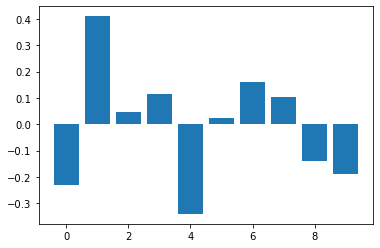

In [204]:
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

#### 2.6.2. CART FI

Veamos ahora la importancia de las características para un árbol de decisión.

In [205]:
# define the model
dtreg = DecisionTreeRegressor()
# fit the model
dtreg.fit(X_scal, y_scal)
# get importance
importance = dtreg.feature_importances_   
print(dtreg.feature_importances_.shape)
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %s, Score: %.5f' % (X_scal.columns[i],v))

(10,)
Feature: Beak.Length_Culmen, Score: 0.03106
Feature: Beak.Length_Nares, Score: 0.18537
Feature: Beak.Width, Score: 0.07109
Feature: Beak.Depth, Score: 0.22382
Feature: Tarsus.Length, Score: 0.36730
Feature: Wing.Length, Score: 0.01198
Feature: Kipps.Distance, Score: 0.00907
Feature: Secondary1, Score: 0.02635
Feature: Hand-wing.Index, Score: 0.04079
Feature: Tail.Length, Score: 0.03317


Aunque los resultados son parecidos (las variables más relevantes son `'Tarsus.Length'` y `'Beak.Length_Nares'`), vemos que la longitud del culmen pierde muchísima importancia a favor de la anchura y la profundidad del pico.

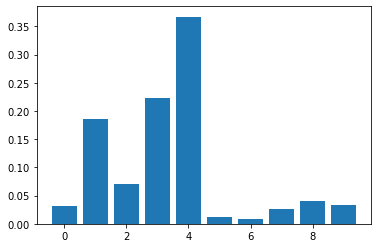

In [206]:
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

#### 2.6.3. Random Forest FI

Pasemos ahora a ver la importancia de las características según un `RandomForest`.

In [207]:
# define the model
rfr = RandomForestRegressor()
# fit the model
rfr.fit(X_scal, y_scal)
# get importance
importance = rfr.feature_importances_
print(rfr.feature_importances_.shape)
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %s, Score: %.5f' % (X_scal.columns[i],v))

(10,)
Feature: Beak.Length_Culmen, Score: 0.02875
Feature: Beak.Length_Nares, Score: 0.22346
Feature: Beak.Width, Score: 0.13162
Feature: Beak.Depth, Score: 0.16480
Feature: Tarsus.Length, Score: 0.33702
Feature: Wing.Length, Score: 0.01448
Feature: Kipps.Distance, Score: 0.01504
Feature: Secondary1, Score: 0.02021
Feature: Hand-wing.Index, Score: 0.03504
Feature: Tail.Length, Score: 0.02958


Las conclusiones son, en esencia, similares a las del árbol de decisión.

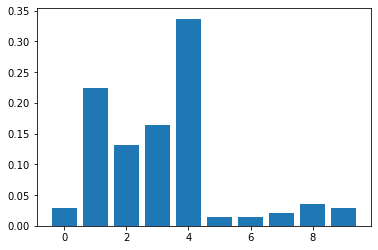

In [208]:
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

#### 2.6.4. Permutation FI

Utilicemos finalmente un modelo KNN para calcular el grado de importancia por permutación.

In [209]:
# define the model
knr = KNeighborsRegressor()
# fit the model
knr.fit(X_scal, y_scal)
# perform permutation importance
results = permutation_importance(knr, X_scal, y_scal, scoring='neg_mean_squared_error')
# get importance
importance = results.importances_mean
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %s, Score: %.5f' % (X_scal.columns[i],v))

Feature: Beak.Length_Culmen, Score: 0.11027
Feature: Beak.Length_Nares, Score: 0.14584
Feature: Beak.Width, Score: 0.13968
Feature: Beak.Depth, Score: 0.10176
Feature: Tarsus.Length, Score: 0.18497
Feature: Wing.Length, Score: 0.04407
Feature: Kipps.Distance, Score: 0.03426
Feature: Secondary1, Score: 0.05485
Feature: Hand-wing.Index, Score: 0.04150
Feature: Tail.Length, Score: 0.14172


Los resultados son similares a los del árbol de decisión y el random forest, pero la última variable, `'Tail.Length'`, también entra en juego con la tercera importancia más elevada junto a la anchura del pico.

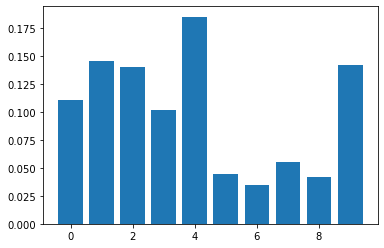

In [210]:
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

### 2.7. Selección de características (FS)

Una vez hemos analizado la importancia de las características, pasemos a seleccionar aquellas con mayor relevancia en nuestros modelos y a obtener sus resultados asociados.

Para ello, importamos los paquetes necesarios y creamos de nuevo un DataFrame que contenga todos nuestros resultados para cada modelo, estrategia de FS y número de características.

In [211]:
scoresFS = pd.DataFrame(columns=['Modelo', 
                               'Estrategia de selección de características',
                               'Número de características',
                               'Accuracy (mean)',
                               'Accuracy (std)',
                               'Selector'])

Cabe destacar que nuestro modelo tiene un bajo número de variables, y de la sección anterior podemos concluir que todas las variables tienen un buen grado de importancia. No obstante, estudiemos los resultados, y veamos a qué conclusión llegamos en base a la precisión obtenida.

#### 2.7.1. FS en base al coeficiente de correlación

Como finalmente nos hemos quedado solo con las variables numéricas, podemos aplicar la FS mediante el coeficiente de correlación.

In [212]:
# split into train and test sets  
X_train, X_test, y_train, y_test = train_test_split(X_scal, y_scal, test_size=0.2, random_state=1)

In [213]:
# feature selection
def select_features(X_train, y_train, X_test):
    # configure to select all features
    fs = SelectKBest(score_func=f_regression, k='all')
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
# what are scores for the features
for i in range(len(fs.scores_)):
    print('Feature %s: %f' % (X_scal.columns[i], fs.scores_[i]))

Feature Beak.Length_Culmen: 535.684370
Feature Beak.Length_Nares: 1649.083631
Feature Beak.Width: 2092.532351
Feature Beak.Depth: 1836.732585
Feature Tarsus.Length: 716.132575
Feature Wing.Length: 180.355926
Feature Kipps.Distance: 199.231472
Feature Secondary1: 175.901944
Feature Hand-wing.Index: 3.761499
Feature Tail.Length: 103.224206


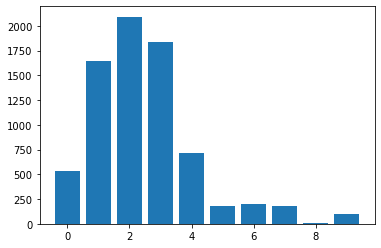

In [214]:
# plot the scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()

In [215]:
%%time

for k in range(2,len(numeric_columns)):

    fs = SelectKBest(score_func=f_regression, k=k)

    pip = Pipeline(steps=[('fs', fs),
                          ('model',  model)])

    # preparar el procedimiento de cross-validation 
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # evaluar el modelo
    cv_results = cross_validate(pip, X_scal, y_scal, scoring='accuracy', cv=cv)

    print('MutualInformation (' + str(k) + ')')
    print('{:s}: {:.2f} ({:.2f})'.format(name, 
                                         mean(cv_results['test_score']), 
                                         std(cv_results['test_score'])))

    scoresFS.loc[len(scoresFS)] = [name,
                               'CorrelationCoefficient',
                               k,
                               mean(cv_results['test_score']),
                               std(cv_results['test_score']),
                               fs]

MutualInformation (2)
Random Forest Classifier: 0.91 (0.01)
MutualInformation (3)
Random Forest Classifier: 0.92 (0.01)
MutualInformation (4)
Random Forest Classifier: 0.98 (0.00)
MutualInformation (5)
Random Forest Classifier: 0.98 (0.00)
MutualInformation (6)
Random Forest Classifier: 0.99 (0.00)
MutualInformation (7)
Random Forest Classifier: 0.99 (0.00)
MutualInformation (8)
Random Forest Classifier: 0.99 (0.00)
MutualInformation (9)
Random Forest Classifier: 0.99 (0.00)
CPU times: total: 9min 37s
Wall time: 4min 49s


In [216]:
scoresFS[scoresFS['Estrategia de selección de características'] == 'CorrelationCoefficient'].sort_values('Accuracy (mean)', ascending=False)

,Modelo,Estrategia de selección de características,Número de características,Accuracy (mean),Accuracy (std),Selector
7,Random Forest Classifier,CorrelationCoefficient,9,0.993132,0.002279,"SelectKBest(k=9, score_func=<function f_regres..."
6,Random Forest Classifier,CorrelationCoefficient,8,0.990953,0.002058,"SelectKBest(k=8, score_func=<function f_regres..."
5,Random Forest Classifier,CorrelationCoefficient,7,0.989792,0.002135,"SelectKBest(k=7, score_func=<function f_regres..."
4,Random Forest Classifier,CorrelationCoefficient,6,0.987637,0.002545,"SelectKBest(k=6, score_func=<function f_regres..."
3,Random Forest Classifier,CorrelationCoefficient,5,0.983279,0.003041,"SelectKBest(k=5, score_func=<function f_regres..."
2,Random Forest Classifier,CorrelationCoefficient,4,0.979418,0.003345,"SelectKBest(k=4, score_func=<function f_regres..."
1,Random Forest Classifier,CorrelationCoefficient,3,0.923002,0.006018,"SelectKBest(k=3, score_func=<function f_regres..."
0,Random Forest Classifier,CorrelationCoefficient,2,0.910520,0.007142,"SelectKBest(k=2, score_func=<function f_regres..."


#### 2.7.3. FS mediante Mutual Information (MI)

Para poder extraer las variables de mayor importancia contemplando comportamientos no lineales (como los que encontramos en algunas de las variables), necesitamos emplear técnicas como la de Mutual Information, basada en la información mutua entre variables aleatorias.

In [217]:
# split into train and test sets  
X_train, X_test, y_train, y_test = train_test_split(X_scal, y_scal, test_size=0.2, random_state=1)

In [218]:
# feature selection
def select_features(X_train, y_train, X_test):
    # configure to select all features
    fs = SelectKBest(score_func=mutual_info_regression, k='all')
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
# what are scores for the features
for i in range(len(fs.scores_)):
    print('Feature %s: %f' % (X_scal.columns[i], fs.scores_[i]))

Feature Beak.Length_Culmen: 0.422299
Feature Beak.Length_Nares: 0.225470
Feature Beak.Width: 0.412168
Feature Beak.Depth: 0.475624
Feature Tarsus.Length: 0.399919
Feature Wing.Length: 0.391209
Feature Kipps.Distance: 0.260251
Feature Secondary1: 0.255014
Feature Hand-wing.Index: 0.256427
Feature Tail.Length: 0.348678


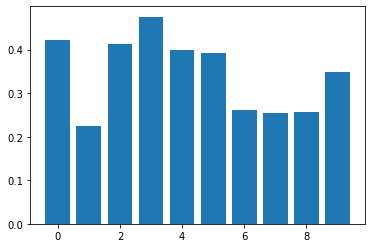

In [219]:
# plot the scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()

In [220]:
%%time

for k in range(2,len(X_train.columns)):

    fs = SelectKBest(score_func=mutual_info_regression, k=k)

    pip = Pipeline(steps=[('fs', fs),
                          ('model',  model)])

    # preparar el procedimiento de cross-validation 
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # evaluar el modelo
    cv_results = cross_validate(pip, X_scal, y_scal, scoring='accuracy', cv=cv)

    print('MutualInformation (' + str(k) + ')')
    print('{:s}: {:.2f} ({:.2f})'.format(name, 
                                         mean(cv_results['test_score']), 
                                         std(cv_results['test_score'])))

    scoresFS.loc[len(scoresFS)] = [name,
                               'MutualInformation',
                               k,
                               mean(cv_results['test_score']),
                               std(cv_results['test_score']),
                               fs]

MutualInformation (2)
Random Forest Classifier: 0.89 (0.01)
MutualInformation (3)
Random Forest Classifier: 0.93 (0.01)
MutualInformation (4)
Random Forest Classifier: 0.98 (0.00)
MutualInformation (5)
Random Forest Classifier: 0.99 (0.00)
MutualInformation (6)
Random Forest Classifier: 0.99 (0.00)
MutualInformation (7)
Random Forest Classifier: 0.99 (0.00)
MutualInformation (8)
Random Forest Classifier: 0.99 (0.00)
MutualInformation (9)
Random Forest Classifier: 0.99 (0.00)
CPU times: total: 7min 13s
Wall time: 7min 13s


In [221]:
scoresFS[scoresFS['Estrategia de selección de características'] == 'MutualInformation'].sort_values('Accuracy (mean)', ascending=False)

,Modelo,Estrategia de selección de características,Número de características,Accuracy (mean),Accuracy (std),Selector
14,Random Forest Classifier,MutualInformation,8,0.992610,0.002072,"SelectKBest(k=8,\n score_func=<func..."
13,Random Forest Classifier,MutualInformation,7,0.992066,0.002187,"SelectKBest(k=7,\n score_func=<func..."
15,Random Forest Classifier,MutualInformation,9,0.991924,0.002498,"SelectKBest(k=9,\n score_func=<func..."
12,Random Forest Classifier,MutualInformation,6,0.991047,0.002945,"SelectKBest(k=6,\n score_func=<func..."
11,Random Forest Classifier,MutualInformation,5,0.986216,0.003381,"SelectKBest(k=5,\n score_func=<func..."
10,Random Forest Classifier,MutualInformation,4,0.976434,0.004524,"SelectKBest(k=4,\n score_func=<func..."
9,Random Forest Classifier,MutualInformation,3,0.928260,0.008177,"SelectKBest(k=3,\n score_func=<func..."
8,Random Forest Classifier,MutualInformation,2,0.891289,0.008154,"SelectKBest(k=2,\n score_func=<func..."


#### 2.7.4. Eliminación Recursiva de Variables (RFE)

Estudiamos a continuación la selección de características mediante la técnica de Eliminación Recursiva de Variables o RFE aplicada mediante un Árbol de Decisión.

In [222]:
%%time

for k in range(2,len(X_train.columns)):

    fs = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=k)  

    pip = Pipeline(steps=[('fs', fs),
                          ('model',  model)])

    # preparar el procedimiento de cross-validation 
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # evaluar el modelo
    cv_results = cross_validate(pip, X_scal, y_scal, scoring='accuracy', cv=cv)

    print('RFE (' + str(k) + ')')
    print('{:s}: {:.2f} ({:.2f})'.format(name, 
                                         mean(cv_results['test_score']), 
                                         std(cv_results['test_score'])))

    scoresFS.loc[len(scoresFS)] = [name,
                               'RFE',
                               k,
                               mean(cv_results['test_score']),
                               std(cv_results['test_score']),
                               fs]

RFE (2)
Random Forest Classifier: 0.92 (0.01)
RFE (3)
Random Forest Classifier: 0.96 (0.01)
RFE (4)
Random Forest Classifier: 0.98 (0.00)
RFE (5)
Random Forest Classifier: 0.98 (0.00)
RFE (6)
Random Forest Classifier: 0.99 (0.00)
RFE (7)
Random Forest Classifier: 0.99 (0.00)
RFE (8)
Random Forest Classifier: 0.99 (0.00)
RFE (9)
Random Forest Classifier: 0.99 (0.00)
CPU times: total: 5min 57s
Wall time: 5min 57s


In [223]:
scoresFS[scoresFS['Estrategia de selección de características'] == 'RFE'].sort_values('Accuracy (mean)', ascending=False)

,Modelo,Estrategia de selección de características,Número de características,Accuracy (mean),Accuracy (std),Selector
22,Random Forest Classifier,RFE,8,0.993108,0.002126,"RFE(estimator=DecisionTreeRegressor(), n_featu..."
23,Random Forest Classifier,RFE,9,0.992753,0.002485,"RFE(estimator=DecisionTreeRegressor(), n_featu..."
21,Random Forest Classifier,RFE,7,0.990668,0.002732,"RFE(estimator=DecisionTreeRegressor(), n_featu..."
20,Random Forest Classifier,RFE,6,0.987897,0.002908,"RFE(estimator=DecisionTreeRegressor(), n_featu..."
19,Random Forest Classifier,RFE,5,0.984842,0.003210,"RFE(estimator=DecisionTreeRegressor(), n_featu..."
18,Random Forest Classifier,RFE,4,0.979418,0.003345,"RFE(estimator=DecisionTreeRegressor(), n_featu..."
17,Random Forest Classifier,RFE,3,0.961702,0.010191,"RFE(estimator=DecisionTreeRegressor(), n_featu..."
16,Random Forest Classifier,RFE,2,0.921675,0.008516,"RFE(estimator=DecisionTreeRegressor(), n_featu..."


#### 2.7.5. FS mediante la importancia según un modelo

Finalmente, vamos a aplicar la selección de características en base a la importancia según un modelo. Concretamente, aplicando los resultados que hemos visto en el punto 2.6.3., vamos a quedarnos con las k variables más importantes según un `RandomForestRegressor`.

In [224]:
%%time

for k in range(2,len(X_train.columns)):

    fs = SelectFromModel(RandomForestRegressor(random_state=123), max_features=k)

    pip = Pipeline(steps=[('fs', fs),
                          ('model',  model)])

    # preparar el procedimiento de cross-validation 
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # evaluar el modelo
    cv_results = cross_validate(pip, X_scal, y_scal, scoring='accuracy', cv=cv)

    print('SelectFromModel (' + str(k) + ')')
    print('{:s}: {:.2f} ({:.2f})'.format(name, 
                                         mean(cv_results['test_score']), 
                                         std(cv_results['test_score'])))

    scoresFS.loc[len(scoresFS)] = [name,
                               'SelectFromModel (RandomForestRegressor importance)',
                               k,
                               mean(cv_results['test_score']),
                               std(cv_results['test_score']),
                               fs]

SelectFromModel (2)
Random Forest Classifier: 0.92 (0.01)
SelectFromModel (3)
Random Forest Classifier: 0.97 (0.00)
SelectFromModel (4)
Random Forest Classifier: 0.98 (0.00)
SelectFromModel (5)
Random Forest Classifier: 0.98 (0.00)
SelectFromModel (6)
Random Forest Classifier: 0.98 (0.00)
SelectFromModel (7)
Random Forest Classifier: 0.98 (0.00)
SelectFromModel (8)
Random Forest Classifier: 0.98 (0.00)
SelectFromModel (9)
Random Forest Classifier: 0.98 (0.00)
CPU times: total: 23min 3s
Wall time: 23min 3s


In [225]:
scoresFS[scoresFS['Estrategia de selección de características'] == 'SelectFromModel (RandomForestRegressor importance)'].sort_values('Accuracy (mean)', ascending=False)

,Modelo,Estrategia de selección de características,Número de características,Accuracy (mean),Accuracy (std),Selector
26,Random Forest Classifier,SelectFromModel (RandomForestRegressor importa...,4,0.979418,0.003345,SelectFromModel(estimator=RandomForestRegresso...
27,Random Forest Classifier,SelectFromModel (RandomForestRegressor importa...,5,0.979418,0.003345,SelectFromModel(estimator=RandomForestRegresso...
28,Random Forest Classifier,SelectFromModel (RandomForestRegressor importa...,6,0.979418,0.003345,SelectFromModel(estimator=RandomForestRegresso...
29,Random Forest Classifier,SelectFromModel (RandomForestRegressor importa...,7,0.979418,0.003345,SelectFromModel(estimator=RandomForestRegresso...
30,Random Forest Classifier,SelectFromModel (RandomForestRegressor importa...,8,0.979418,0.003345,SelectFromModel(estimator=RandomForestRegresso...
31,Random Forest Classifier,SelectFromModel (RandomForestRegressor importa...,9,0.979418,0.003345,SelectFromModel(estimator=RandomForestRegresso...
25,Random Forest Classifier,SelectFromModel (RandomForestRegressor importa...,3,0.967339,0.003627,SelectFromModel(estimator=RandomForestRegresso...
24,Random Forest Classifier,SelectFromModel (RandomForestRegressor importa...,2,0.923191,0.006772,SelectFromModel(estimator=RandomForestRegresso...


#### 2.7.6. Contraste de resultados

Comparando los resultados obtenidos por los distintos modelos podemos ver cuáles son las mejores combinaciones de técnicas de selección de características con número de variables para el problema que estamos tratando.

Como comentábamos anteriormente, los resultados no mejoran bajo ninguna selección de características, sino que se van reduciendo progresivamente a medida que reducimos su número. No aplicaremos estas técnicas en las siguientes secciones.

In [226]:
k_max = 10
scoresFS[scoresFS['Número de características'] <= k_max].sort_values('Accuracy (mean)', ascending=False).head(15)

,Modelo,Estrategia de selección de características,Número de características,Accuracy (mean),Accuracy (std),Selector
7,Random Forest Classifier,CorrelationCoefficient,9,0.993132,0.002279,"SelectKBest(k=9, score_func=<function f_regres..."
22,Random Forest Classifier,RFE,8,0.993108,0.002126,"RFE(estimator=DecisionTreeRegressor(), n_featu..."
23,Random Forest Classifier,RFE,9,0.992753,0.002485,"RFE(estimator=DecisionTreeRegressor(), n_featu..."
14,Random Forest Classifier,MutualInformation,8,0.992610,0.002072,"SelectKBest(k=8,\n score_func=<func..."
13,Random Forest Classifier,MutualInformation,7,0.992066,0.002187,"SelectKBest(k=7,\n score_func=<func..."
15,Random Forest Classifier,MutualInformation,9,0.991924,0.002498,"SelectKBest(k=9,\n score_func=<func..."
12,Random Forest Classifier,MutualInformation,6,0.991047,0.002945,"SelectKBest(k=6,\n score_func=<func..."
6,Random Forest Classifier,CorrelationCoefficient,8,0.990953,0.002058,"SelectKBest(k=8, score_func=<function f_regres..."
21,Random Forest Classifier,RFE,7,0.990668,0.002732,"RFE(estimator=DecisionTreeRegressor(), n_featu..."
5,Random Forest Classifier,CorrelationCoefficient,7,0.989792,0.002135,"SelectKBest(k=7, score_func=<function f_regres..."


### 2.8. Transformaciones polinomiales

Como último recurso, probemos a aplicar un filtro `PolynomialFeatures`.

In [227]:
scoresPF = pd.DataFrame(columns=['Modelo', 
                               'Grado',
                               'Accuracy (mean)',
                               'Accuracy (std)'])

In [228]:
%%time
from sklearn.preprocessing import PolynomialFeatures

for degree in range(1,6):

    trans = PolynomialFeatures(degree=degree)

    pip = Pipeline(steps=[('pf', trans),
                          ('model',  model)])

    # preparar el procedimiento de cross-validation 
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # evaluar el modelo
    cv_results = cross_validate(pip, X_scal, y_scal, scoring='accuracy', cv=cv)

    print(degree)
    print('{:s}: {:.2f} ({:.2f})'.format(name, 
                                         mean(cv_results['test_score']), 
                                         std(cv_results['test_score'])))

    scoresPF.loc[len(scoresPF)] = [name,
                                 degree,
                                 mean(cv_results['test_score']),
                                 std(cv_results['test_score'])]

1
Random Forest Classifier: 0.99 (0.00)
2
Random Forest Classifier: 0.99 (0.00)
3
Random Forest Classifier: 0.99 (0.00)
4
Random Forest Classifier: 0.99 (0.00)
5
Random Forest Classifier: 0.99 (0.00)
CPU times: total: 38min 58s
Wall time: 38min 59s


Vemos que los resultados no mejoran el base (con grado 1), por lo que descartaremos esta técnica también.

In [229]:
scoresPF.sort_values('Accuracy (mean)', ascending=False)

,Modelo,Grado,Accuracy (mean),Accuracy (std)
0,Random Forest Classifier,1,0.993132,0.002181
1,Random Forest Classifier,2,0.993013,0.001622
2,Random Forest Classifier,3,0.991260,0.002211
3,Random Forest Classifier,4,0.991000,0.001838
4,Random Forest Classifier,5,0.989958,0.002452


## 3. Conclusiones

Los resultados obtenidos son realmente buenos, gracias a la aplicación de técnicas de imputación de nulos y de escalado de los datos principalmente. Al trabajar con datos morfológicos métricos de distintas especies de animales, las relaciones entre ellos y las distintas escalas son realmente importantes, por lo que es normal que sean innecesarias técnicas de selección de características o de aumentos polinomiales. Si contáramos con la ayuda de un experto en el tema, podríamos haber extraído más conclusiones como esta que nos ahorraran esfuerzo y tiempo de computación.

Por otro lado, hemos podido trabajar con un problema de clasificación (en el trabajo alternativo tratábamos un problema de regresión), y hemos podido ver cómo (salvo quizá por la codificación de la variable objetivo mediante un LabelEncoder previo) es posible trabajar de forma bastante similar, escogiendo correctamente las métricas del problema.

Cómo último esfuerzo del proyecto, reunamos el conjunto de técnicas determinadas como óptimas y mostremos los resultados para una división train-test del 80%-20%:

In [230]:
%%time

X = df.loc[:,(df.columns != 'Order1') & (df.columns != 'Sex') & (df.columns != 'Measurer')]
y = df.loc[:,df.columns == 'Order1']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

nullImputer = IterativeImputer(estimator=linear_model.Lasso(alpha=0.1), 
                     n_nearest_features=None, 
                     imputation_order='arabic', 
                     max_iter=10000, 
                     tol=0.1)

X_train = nullImputer.fit_transform(X_train)
X_test = nullImputer.transform(X_test)

scaler = QuantileTransformer(n_quantiles=75, output_distribution='normal')

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

rfc = RandomForestClassifier(random_state=123)

rfc.fit(X_train, y_train)
y_hat = rfc.predict(X_test)

score = accuracy_score(y_test, y_hat)

print('Dataset: No few values columns')
print('Modelo: Random Forest Classifier')
print('Estrategia de imputación: IterativeImputer')
print('Transformación y escalado: Quantile Transformer')
print('Accuracy: %.6f' % score)

Dataset: No few values columns
Modelo: Random Forest Classifier
Estrategia de imputación: IterativeImputer
Transformación y escalado: Quantile Transformer
Accuracy: 0.984890
CPU times: total: 1.83 s
Wall time: 886 ms
